## 요약
- XGB를 이용하여 여러가지 상황에서의 성능 확인
- hyperparameter 차이에 따른 성능 차이
  - grid search 이용해서 찾은 hyperparameter가 default일 때보다 성능이 다소 우위
- train set에 SalesPoint를 포함 했을 때와 포함하지 않았을 때
  - SalesPoint
- val, test set 전체에서의 성능과, train에 포함된 적 없는 도서에 대한 데이터로 제한했을 때의 성능
  - hyperparameter가 default일 때의 성능이 다소 우위

In [ ]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [ ]:
from itertools import repeat, chain

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

ValueError: mount failed

In [ ]:
#cd /content/drive/MyDrive/AI3_prjct2_aladin/

In [ ]:
cd /content/drive/MyDrive/WASSUP-ESTsoft-AI/project/project2/

/content/drive/MyDrive/WASSUP-ESTsoft-AI/project/project2


In [ ]:
# 로컬에서

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
#PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
PRJCT_PATH = '/content/drive/MyDrive/WASSUP-ESTsoft-AI/project/project2/'
#PRJCT_PATH = '/content/drive/MyDrive/AI3_prjct2_aladin/aladin_usedbook/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)
dir_path = './'

In [ ]:
ls

 aladin_usedbook.gslides                  module_aladin/   research/
'aladin_usedbook 발표자료 초고.gslides'   processed/


In [ ]:
import sys
sys.path.append(PRJCT_PATH)

In [ ]:
import re
def erase_num_comma(text):
    pat = r'\d\,\d'
    idx_list = sorted([m.start()+1 for m in re.finditer(pat,text)])
    temp = list(text)
    for i in idx_list[::-1]:
        temp.pop(i)
    return ''.join(temp)

In [ ]:
import pickle

def load_pkl(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)

    return data

- (0,5) : category
- (5,35) : BName
- (35,60) : BName_sub

In [ ]:
## FUNCTIONS - DATA- SCORE REG RSLT

def mase_nontime(actual,pred,base_pred) -> np.ndarray:
    """
    MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    :param forecast: Forecast values. Shape: batch, time_o
    :param insample: Insample values. Shape: batch, time_i
    :param outsample: Target values. Shape: batch, time_o
    :param frequency: Frequency value
    :return: Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(actual - pred)) / np.mean(np.abs(actual - base_pred),)

def make_reg_score_dict(y_actual,y_pred,base_val):
    rmse_model, rmse_base = np.sqrt(mse(y_actual,y_pred)), np.sqrt(mse([base_val]*len(y_actual),y_actual))
    mape_model, mape_base = mape(y_actual,y_pred), mape([base_val]*len(y_actual),y_actual)
    mase_model, mase_base = mase_nontime(y_actual,y_pred,base_val),1
    r2_model, r2_base = r2_score(y_actual,y_pred), 0

    return {
        'rmse' : [rmse_model, rmse_base],
        'mape' : [mape_model, mape_base],
        'mase' : [mase_model, mase_base],
        'r2_score' : [r2_model,r2_base]
    }

def print_reg_score_dict(name,dict_score,cut_line=True):
    print('{}\nr2 score : {:.5f}'.format(name,dict_score['r2_score'][0]))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score['mape']))
    if cut_line : print('-'*150)

def make_reg_score_entire(dict_data,dict_rslt,print_rslt=False):
    dict_score = dict()
    for col, val in dict_data.items():
        X = val['X']
        y_actual = val['y']
        y_pred = dict_rslt[col]
        dict_score[col] = make_reg_score_dict(y_actual,y_pred,np.mean(y_actual))
        if print_rslt : print_reg_score_dict(col,dict_score[col])
    return dict_score

In [ ]:
def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e)
    return rslt

In [ ]:
def plot_reg_score(dict_data,dict_rslt,dict_score):
    fig,axes = plt.subplots(len(dict_data),3,figsize=(15,4*len(dict_data)))
    for n, (col,data) in enumerate(dict_data.items()):
        ax_row = axes[n] if len(dict_data) > 1 else axes
        ax1, ax2, ax3 = ax_row[0], ax_row[1], ax_row[2]
        y_actual, y_pred = (data['y'], dict_rslt[col])
        train_y = dict_data['train']['y']
        base_pred = np.mean(train_y)

        sns.histplot(y_actual,label='actual',ax=ax1,alpha=0.5)
        sns.histplot(y_pred,label='pred',ax=ax1,alpha=0.5)
        ax1.legend(fontsize=9)

        sns.histplot(y_actual-base_pred,ax=ax2, label = 'baseline',alpha=0.5)
        sns.histplot(y_actual-y_pred,ax=ax2, label = 'pred',alpha=0.5)
        ax2.legend(fontsize=9)
        ax2.set_title('distribution of errors',fontsize=10)

        df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
        xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
        ax3r = ax3.twinx()
        sns.barplot(x=xs[:2],y=list(df_score.values.reshape(-1))[:2],
                    hue = ['pred','base']*1,ax=ax3,alpha=0.65,legend=False)
        sns.barplot(x=xs[2:],y=list(df_score.values.reshape(-1))[2:],
                    hue = ['pred','base']*3,ax=ax3r,alpha=0.8,legend=False)
        ax3r.set_ylim([0.0,1.15])
        ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
        ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
        ax3.grid(False)
        ax3r.grid(False)
        ax3r.set_yscale('linear')
        ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
        ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
        ax3.set_title('model score',fontsize=10)

        ax1.set_title(str_cutter(col+':distribution of data',50),fontsize=15,loc='left',ha='left')
        ax2.xaxis.set_label_coords(-0.02, -0.15)
        ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
            f'n = {len(y_actual)}'), fontsize=10,ha ='left')
        ax1.set_xlabel('')
        ax3.set_xlabel('')
        ax1.set_ylabel('count',fontsize =10)
        ax2.set_ylabel('count',fontsize =10)
        plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
        plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

    return fig, axes

# 전체 데이터에 적용

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

## XGB

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
model_xgb = XGBRegressor(tree_method="hist", device="cuda")

In [ ]:
model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred1 = model_xgb.predict(X_train)
y_pred2 = model_xgb.predict(X_val)
y_pred3 = model_xgb.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:21:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
dict_data = {
    'train':{'X':X_train,'y':y_train},
    'val':{'X':X_val,'y':y_val},
    'test':{'X':X_test,'y':y_test},
}
dict_rslt = {
    'train':y_pred1,
    'val':y_pred2,
    'test':y_pred3,
}


In [ ]:
reg_score_dict = make_reg_score_entire(dict_data,dict_rslt,print_rslt=True)

train
r2 score : 0.96226
rmse_model : 732.46940 / rmse_base : 3770.41936	 mape_model : 0.08017 / mape_base : 0.35823	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.95714
rmse_model : 779.51843 / rmse_base : 3765.52438	 mape_model : 0.08083 / mape_base : 0.35857	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.95539
rmse_model : 791.44885 / rmse_base : 3747.06972	 mape_model : 0.08123 / mape_base : 0.36010	
------------------------------------------------------------------------------------------------------------------------------------------------------


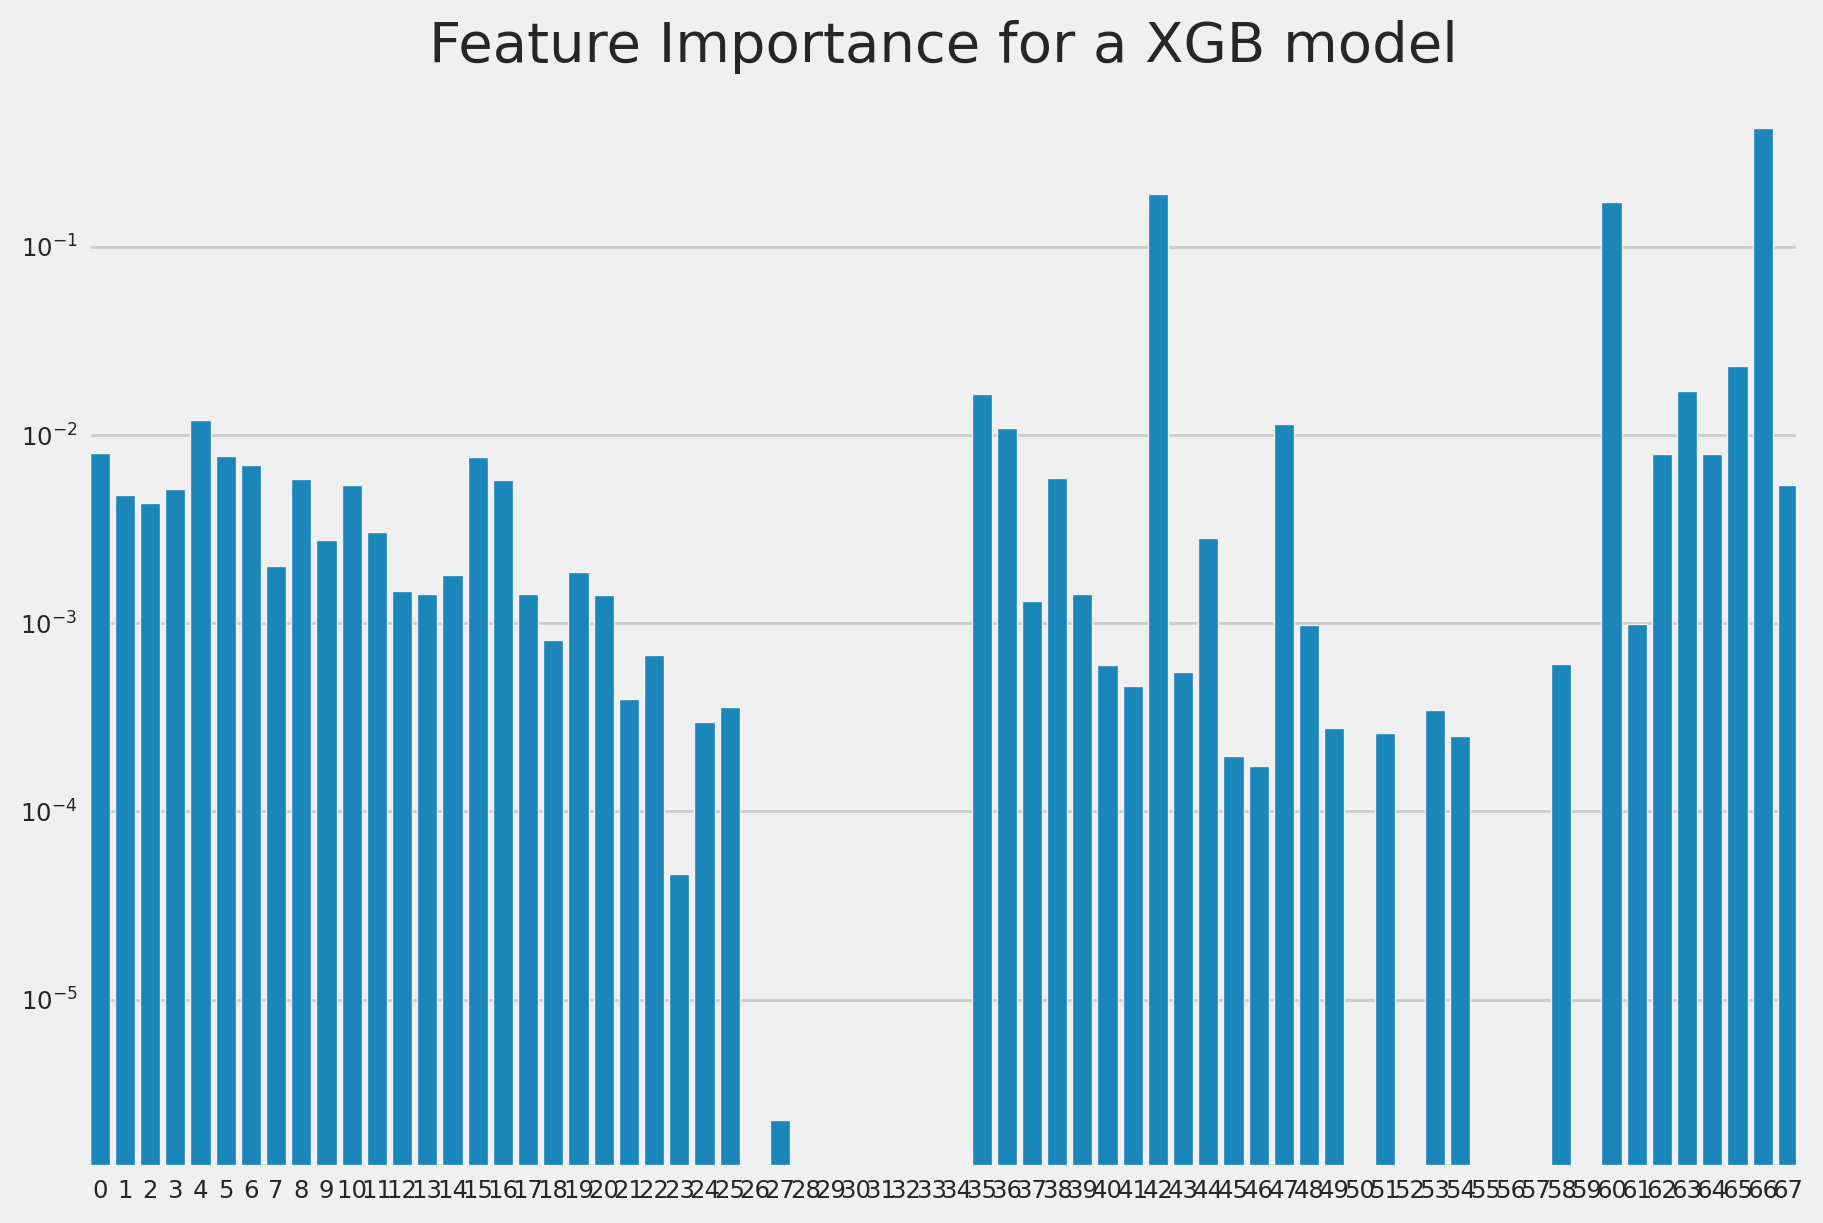

In [ ]:
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(model_xgb.feature_importances_,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a XGB model')
#ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
pass

In [ ]:
crop=False
crop_idx=[]

In [ ]:
col_vector = ['Category','BName','BName_sub']

In [ ]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
 'SalesPoint']

In [ ]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]

In [ ]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
fi_model =model_xgb.feature_importances_
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.03423579,
  'BName': 0.058885768,
  'BName_sub': 0.24477476,
  'quality': 0.17291862,
  'store': 0.0009932424,
  'Author': 0.007872681,
  'Author_mul': 0.01702369,
  'Publshr': 0.0079449285,
  'Pdate': 0.02328786,
  'RglPrice': 0.42666468,
  'SalesPoint': 0.005397885},
 0.9999999030260369)

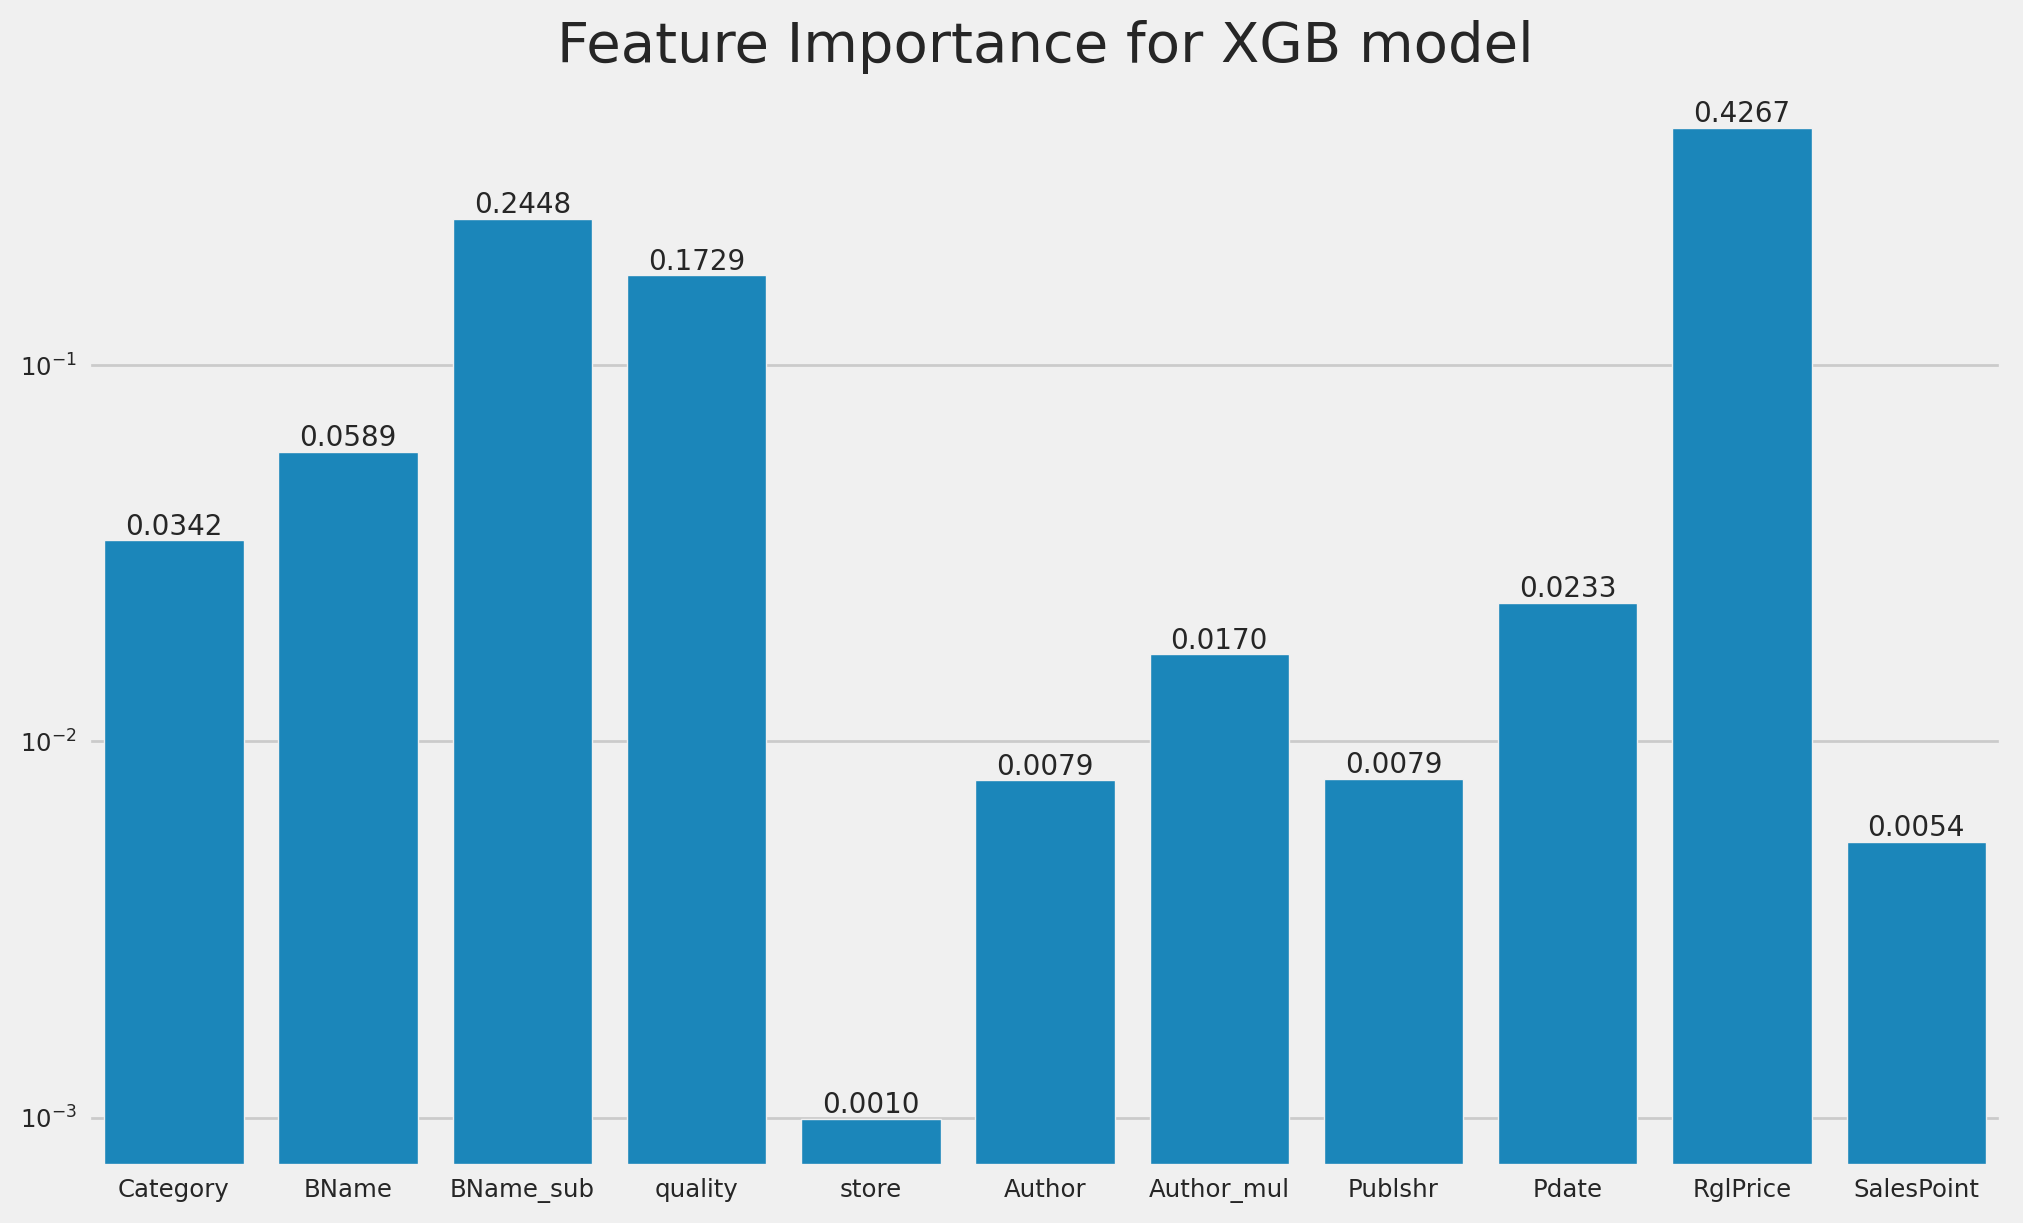

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for XGB model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

In [ ]:
model_xgb_best1 = XGBRegressor(tree_method="hist",
  colsample_bytree= 1,
  device= 'cuda',
  learning_rate= 0.5,
  max_depth= 5,
  n_estimators= 2100)

In [ ]:
model_xgb_best2 = XGBRegressor(tree_method="hist",
  colsample_bytree= 0.5,
  device= 'cuda',
  learning_rate= 0.5,
  max_depth= 5,
  n_estimators= 2100)

In [ ]:
model_xgb_best1.fit(X_train,y_train)
model_xgb_best2.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred11 = model_xgb_best1.predict(X_train)
y_pred12 = model_xgb_best1.predict(X_val)
y_pred13 = model_xgb_best1.predict(X_test)

y_pred21 = model_xgb_best2.predict(X_train)
y_pred22 = model_xgb_best2.predict(X_val)
y_pred23 = model_xgb_best2.predict(X_test)

In [ ]:
dict_rslt_best1 = {
    'train':y_pred11,
    'val':y_pred12,
    'test':y_pred13,
}

dict_rslt_best2 = {
    'train':y_pred21,
    'val':y_pred22,
    'test':y_pred23,
}

In [ ]:
reg_score_dict_best1 = make_reg_score_entire(dict_data,dict_rslt_best1,print_rslt=True)
reg_score_dict_best2 = make_reg_score_entire(dict_data,dict_rslt_best2,print_rslt=True)

train
r2 score : 0.98500
rmse_model : 461.79071 / rmse_base : 3770.41936	 mape_model : 0.05507 / mape_base : 0.35823	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.97076
rmse_model : 643.88934 / rmse_base : 3765.52438	 mape_model : 0.06547 / mape_base : 0.35857	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.97213
rmse_model : 625.51432 / rmse_base : 3747.06972	 mape_model : 0.06560 / mape_base : 0.36010	
------------------------------------------------------------------------------------------------------------------------------------------------------
train
r2 score : 0.98345
rmse_model : 485.07318 / rmse_base : 3770.41936	 mape_model : 0.05772 / mape_base : 0.35823	
------------------------------------------------------------------------------

(<Figure size 1500x1200 with 12 Axes>,
 array([[<Axes: title={'left': 'train:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 461.791 | rmse_base : 3770.419\nr2 score : 0.985                                       n = 501896\n', ylabel='count'>,
         <Axes: title={'center': 'model score'}>],
        [<Axes: title={'left': 'val:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 643.889 | rmse_base : 3765.524\nr2 score : 0.971                                       n = 125474\n', ylabel='count'>,
         <Axes: title={'center': 'model score'}>],
        [<Axes: title={'left': 'test:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 625.514 | rmse_base : 3747.070\nr2 score : 0.972                                       n = 156843\n', ylabel='count'>,
         <Axes: title={'c

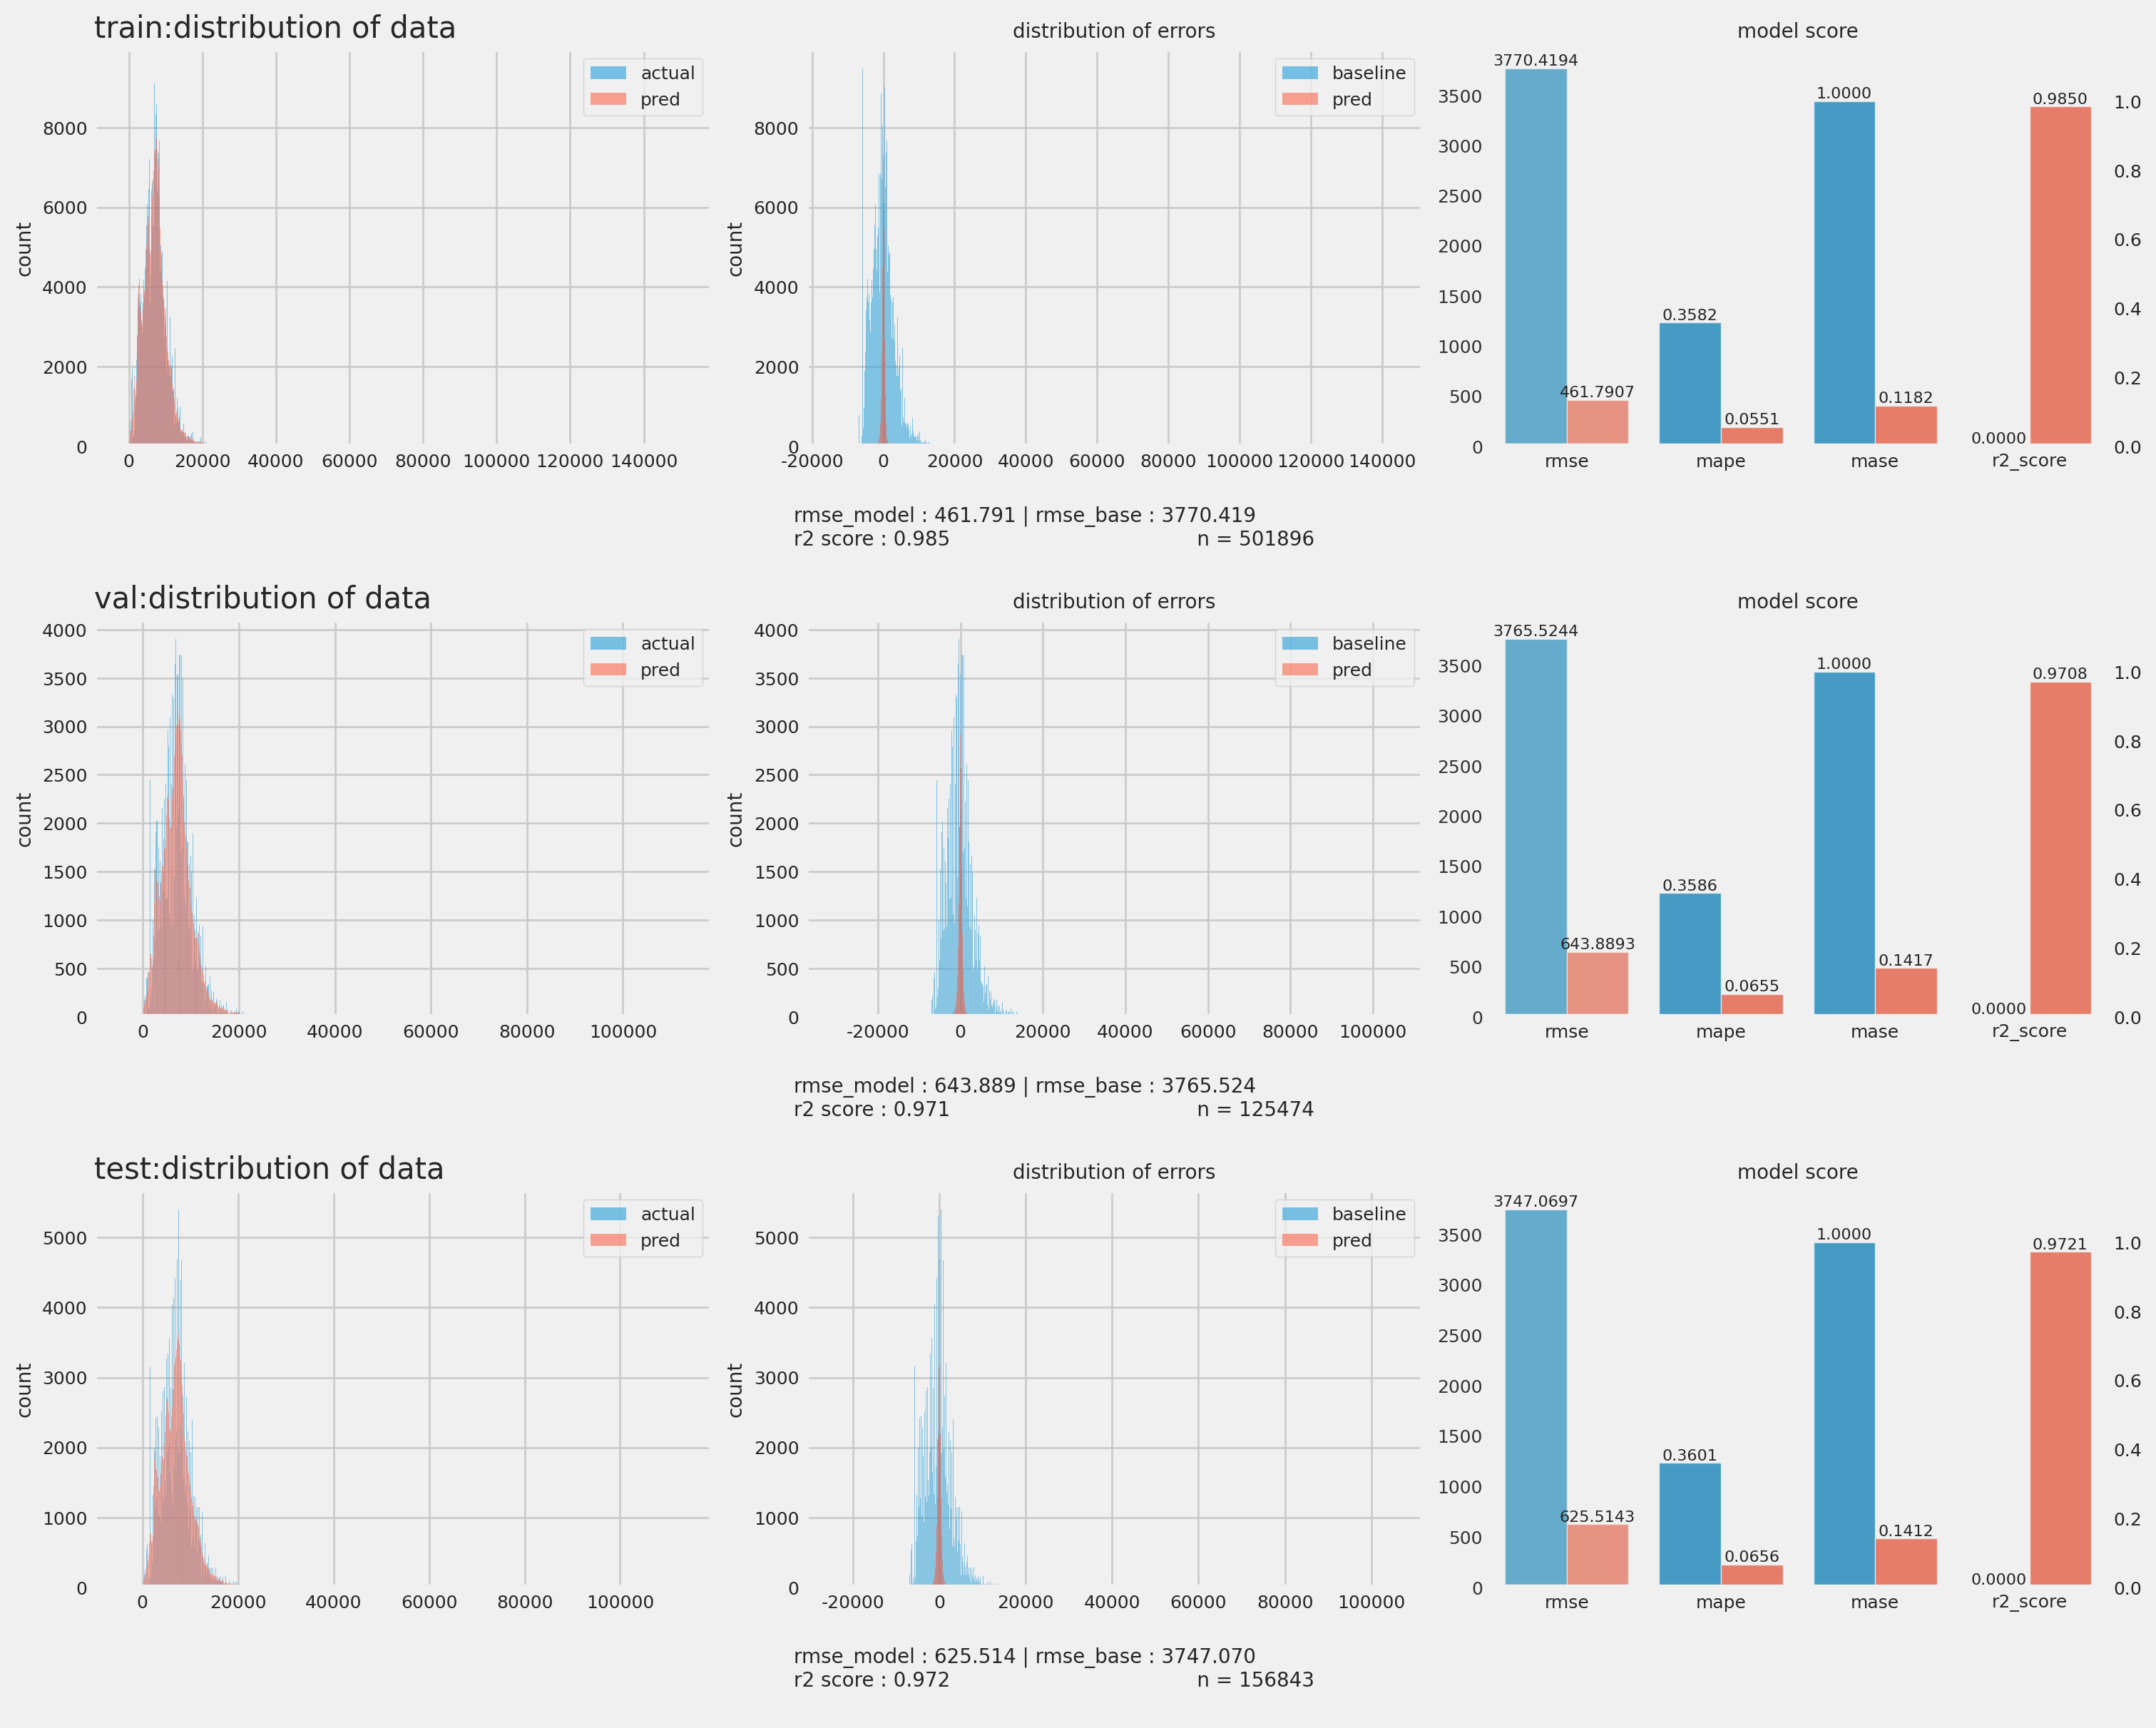

In [ ]:
plot_reg_score(dict_data,dict_rslt_best1,reg_score_dict_best1)

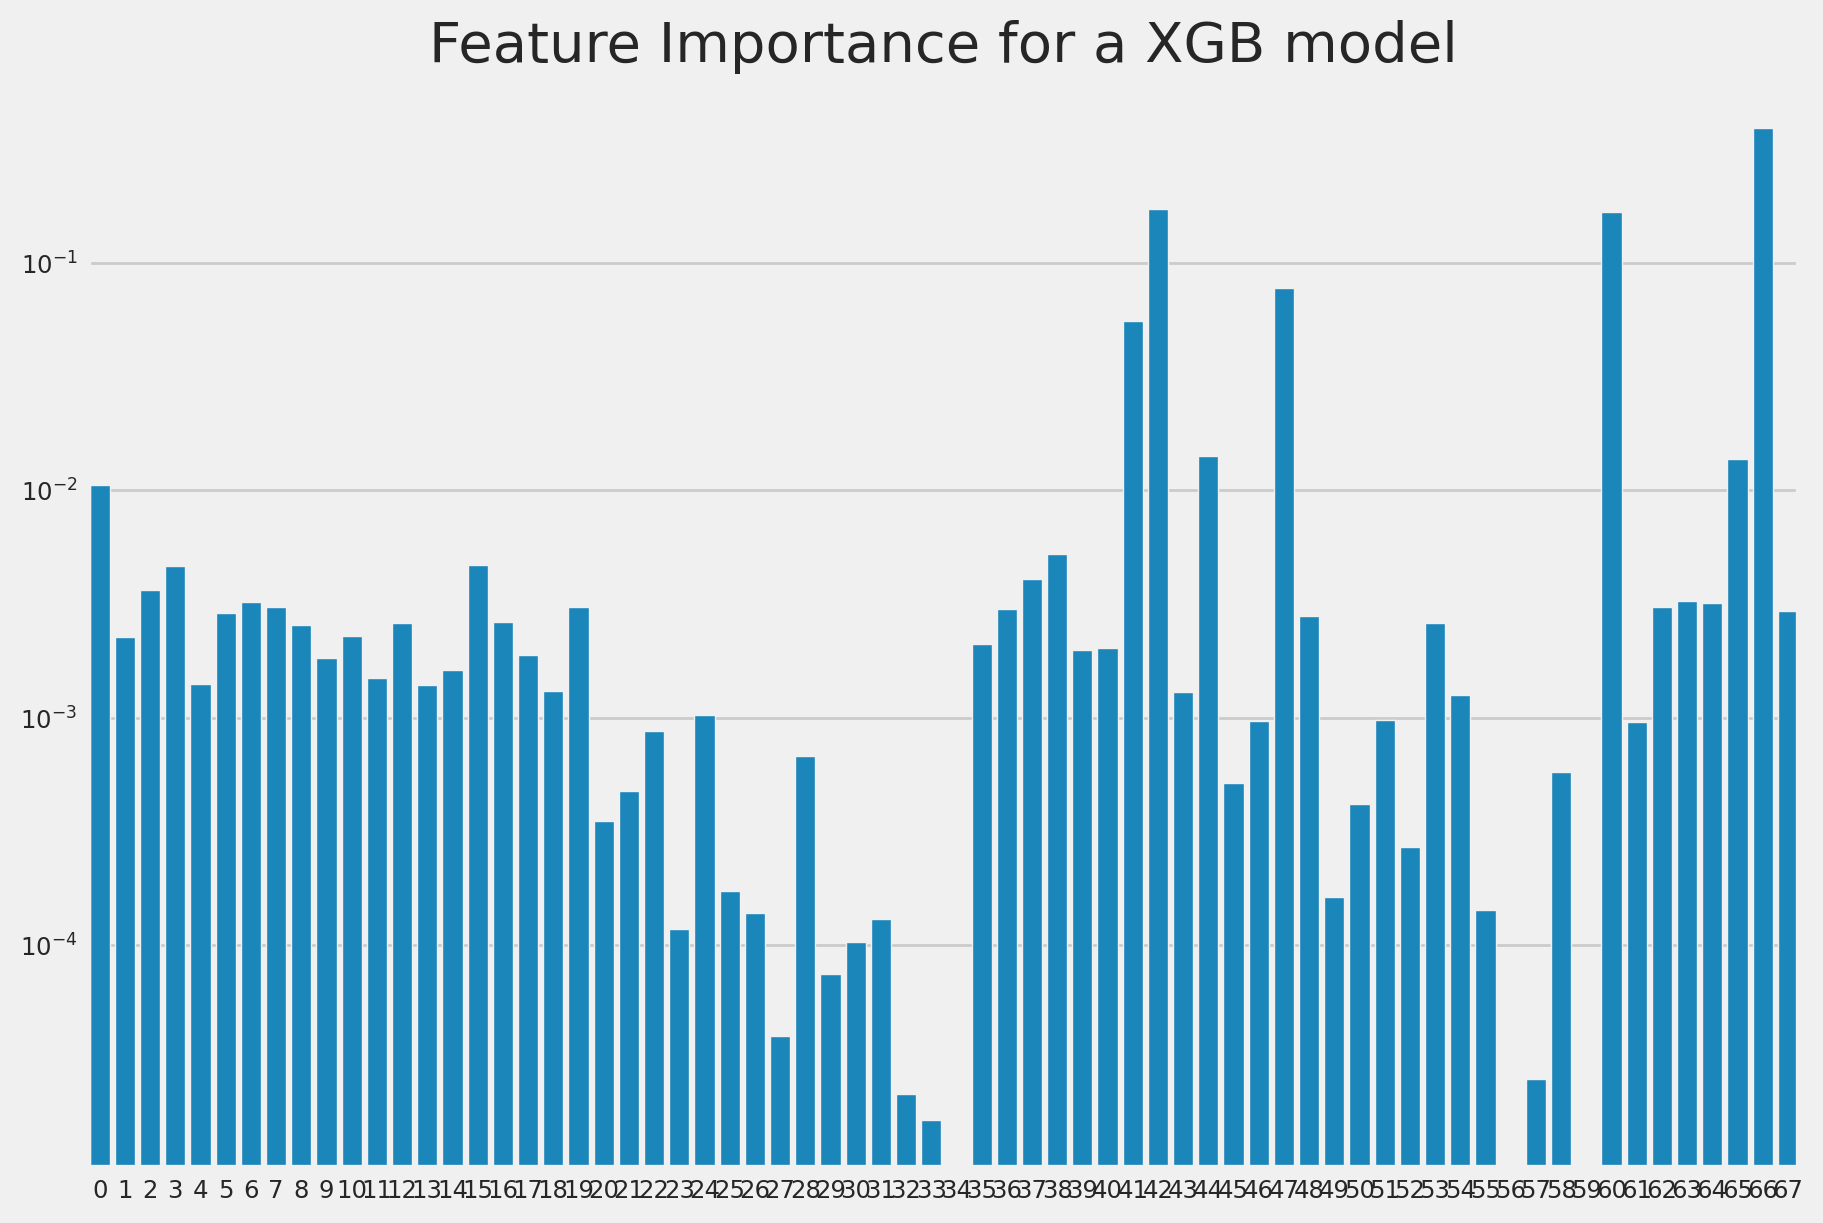

In [ ]:
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(model_xgb_best1.feature_importances_,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a XGB model')
#ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
pass

In [ ]:
crop=False
crop_idx=[]

In [ ]:
col_vector = ['Category','BName','BName_sub']

In [ ]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
 'SalesPoint']

In [ ]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
col_partition

[(0, 5),
 (5, 35),
 (35, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (64, 65),
 (65, 66),
 (66, 67),
 (67, 68)]

In [ ]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
fi_model =model_xgb_best1.feature_importances_
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.022544561,
  'BName': 0.040765475,
  'BName_sub': 0.35003433,
  'quality': 0.16768102,
  'store': 0.00095369713,
  'Author': 0.0030629898,
  'Author_mul': 0.0032713322,
  'Publshr': 0.0031941207,
  'Pdate': 0.01372893,
  'RglPrice': 0.3918212,
  'SalesPoint': 0.0029423353},
 0.999999996740371)

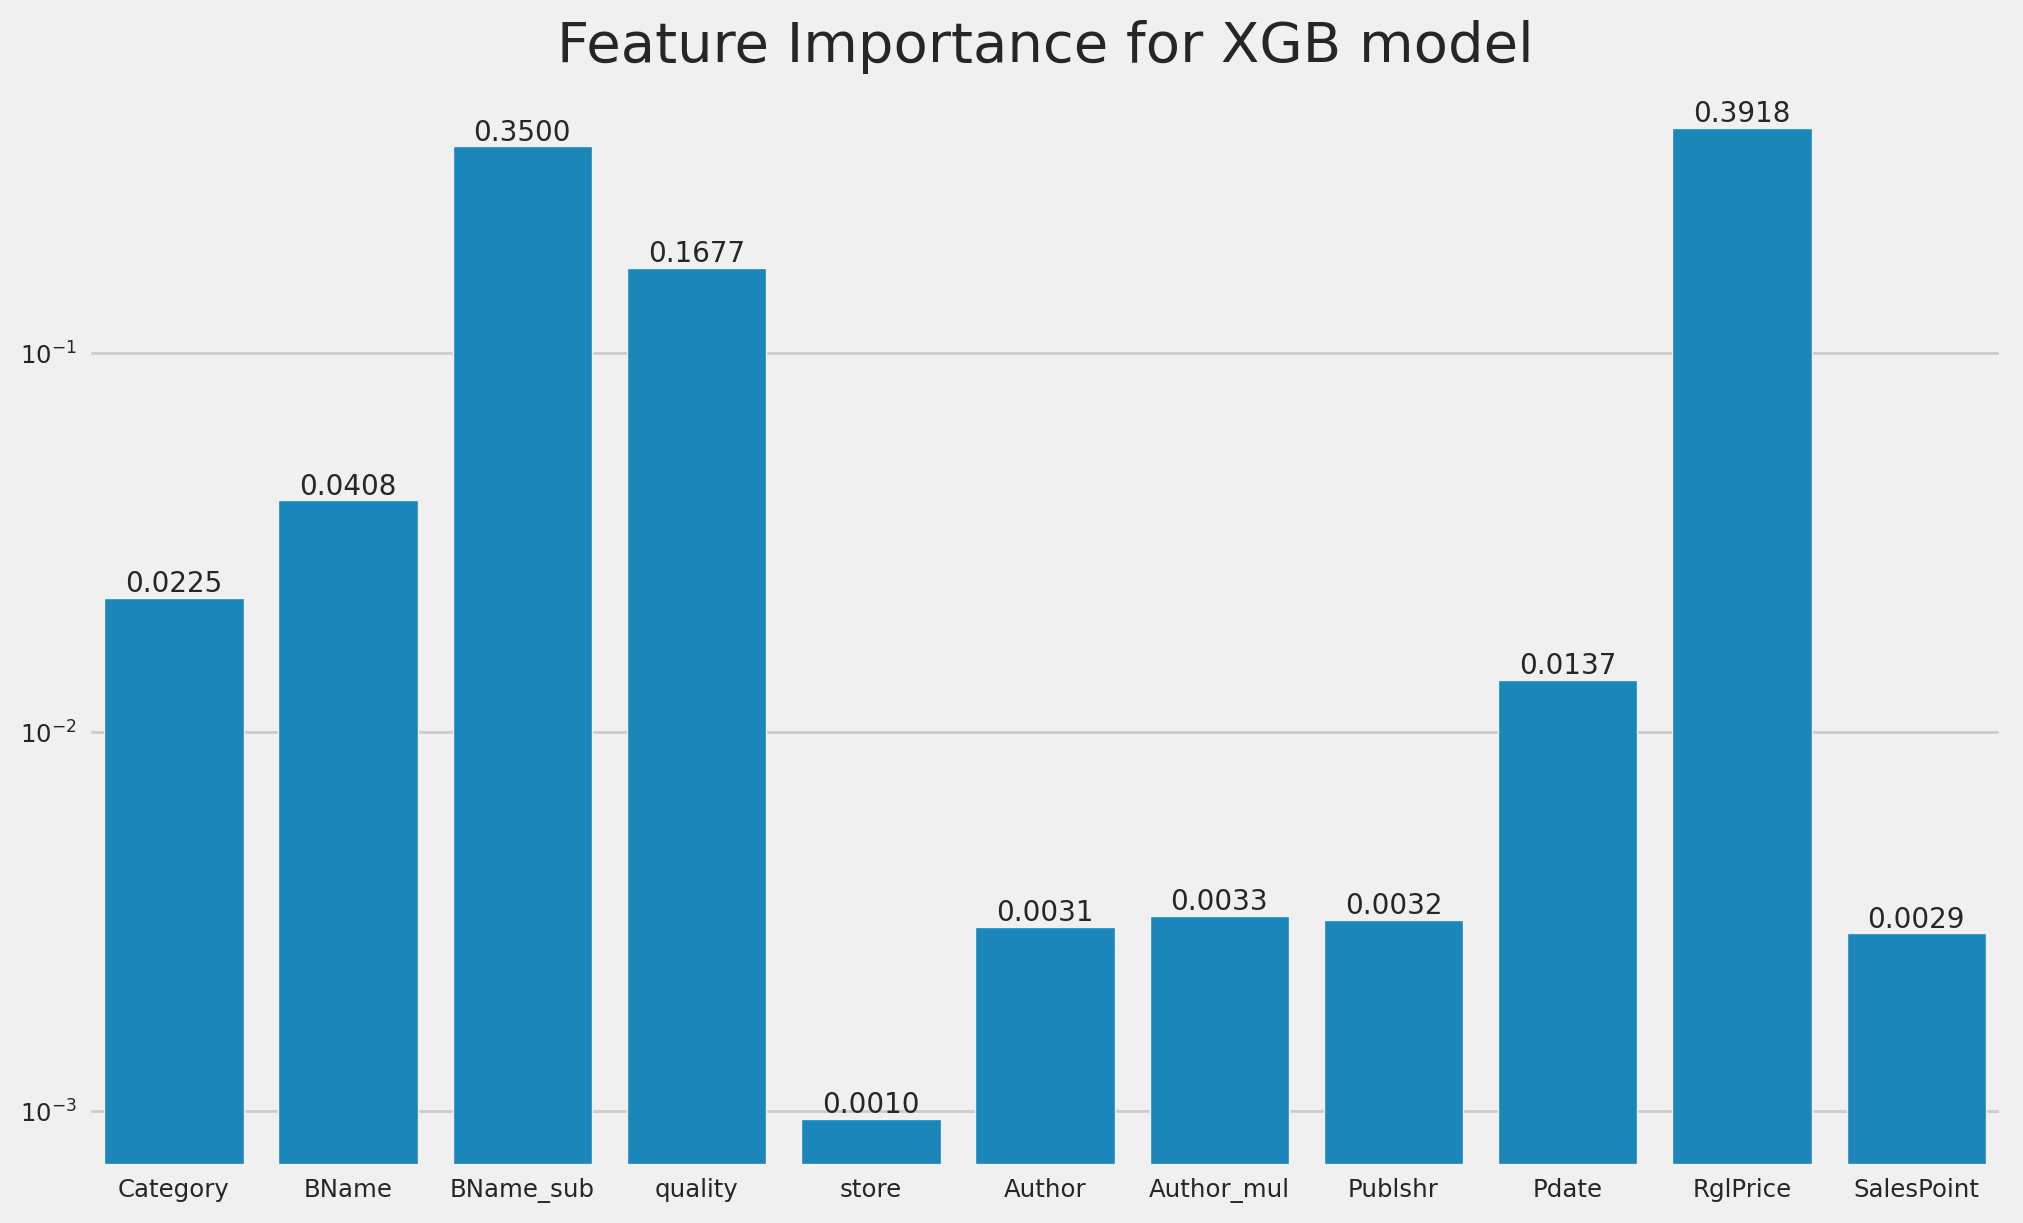

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for XGB model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

- 만약 ItemId가 포함되지 않은 것들로 test set을 추리면 어떻게 될까

In [ ]:
#RSLT_DIR = PRJCT_PATH + 'processed/'
RSLT_DIR = './'
ver, strat = 1.0, False
file_name = 'data_splitted_ver{}_strat-{}.pkl'.format(ver,strat)
file_path = os.path.join(RSLT_DIR,file_name)
data = load_pkl(file_path)

file_name = 'bookinfo_ver{}.csv'.format(1.0)
file_path = os.path.join(RSLT_DIR,file_name)
bookinfo = pd.read_csv(file_path)

items=dict()
for mode,sample in data.items():
    items[mode]= set(sample['X']['ItemId'].values)

In [ ]:
display(len(items['val'].difference(items['train'])))
display(len(items['test'].difference(items['train'])))


4084

4984

In [ ]:
res_val = list(items['val'].difference(items['train']))
res_test = list(items['test'].difference(items['train']))
res_items = res_val+res_test
len(res_items)

9068

In [ ]:
cond_val_res = data['val']['X']['ItemId'].isin(res_val).to_numpy()
cond_test_res = data['test']['X']['ItemId'].isin(res_val).to_numpy()
display(np.sum(cond_val_res))
display(np.sum(cond_test_res))

4677

1451

In [ ]:
len(cond_val_res), len(cond_test_res)

(125474, 156843)

In [ ]:
len(y_val[cond_val_res]),len(y_test[cond_test_res])

(4677, 1451)

In [ ]:
X_res = np.vstack((X_val[cond_val_res],X_test[cond_test_res]))
y_res = np.hstack((y_val[cond_val_res],y_test[cond_test_res]))
X_res.shape, y_res.shape

((6128, 68), (6128,))

In [ ]:
pred4 = model_xgb.predict(X_res)
pred14 = model_xgb_best1.predict(X_res)
pred24 = model_xgb_best2.predict(X_res)

In [ ]:
print("default model")
display(make_reg_score_dict(y_res,pred4,np.mean(y_train)))
print("\nbest model")
display(make_reg_score_dict(y_res,pred14,np.mean(y_train)))
print("\nbest model2")
display(make_reg_score_dict(y_res,pred24,np.mean(y_train)))

default model


{'rmse': [1413.1101855867562, 4837.522729624746],
 'mape': [0.14340198422410336, 0.5005390315845578],
 'mase': [0.17469494393983395, 1],
 'r2_score': [0.9123189180297024, 0]}


best model


{'rmse': [1615.4461208834139, 4837.522729624746],
 'mape': [0.16670323034518436, 0.5005390315845578],
 'mase': [0.19874977632411522, 1],
 'r2_score': [0.8854120889214936, 0]}


best model2


{'rmse': [1882.2801056246503, 4837.522729624746],
 'mape': [0.1683844548838945, 0.5005390315845578],
 'mase': [0.20266661920189977, 1],
 'r2_score': [0.8444312540256, 0]}

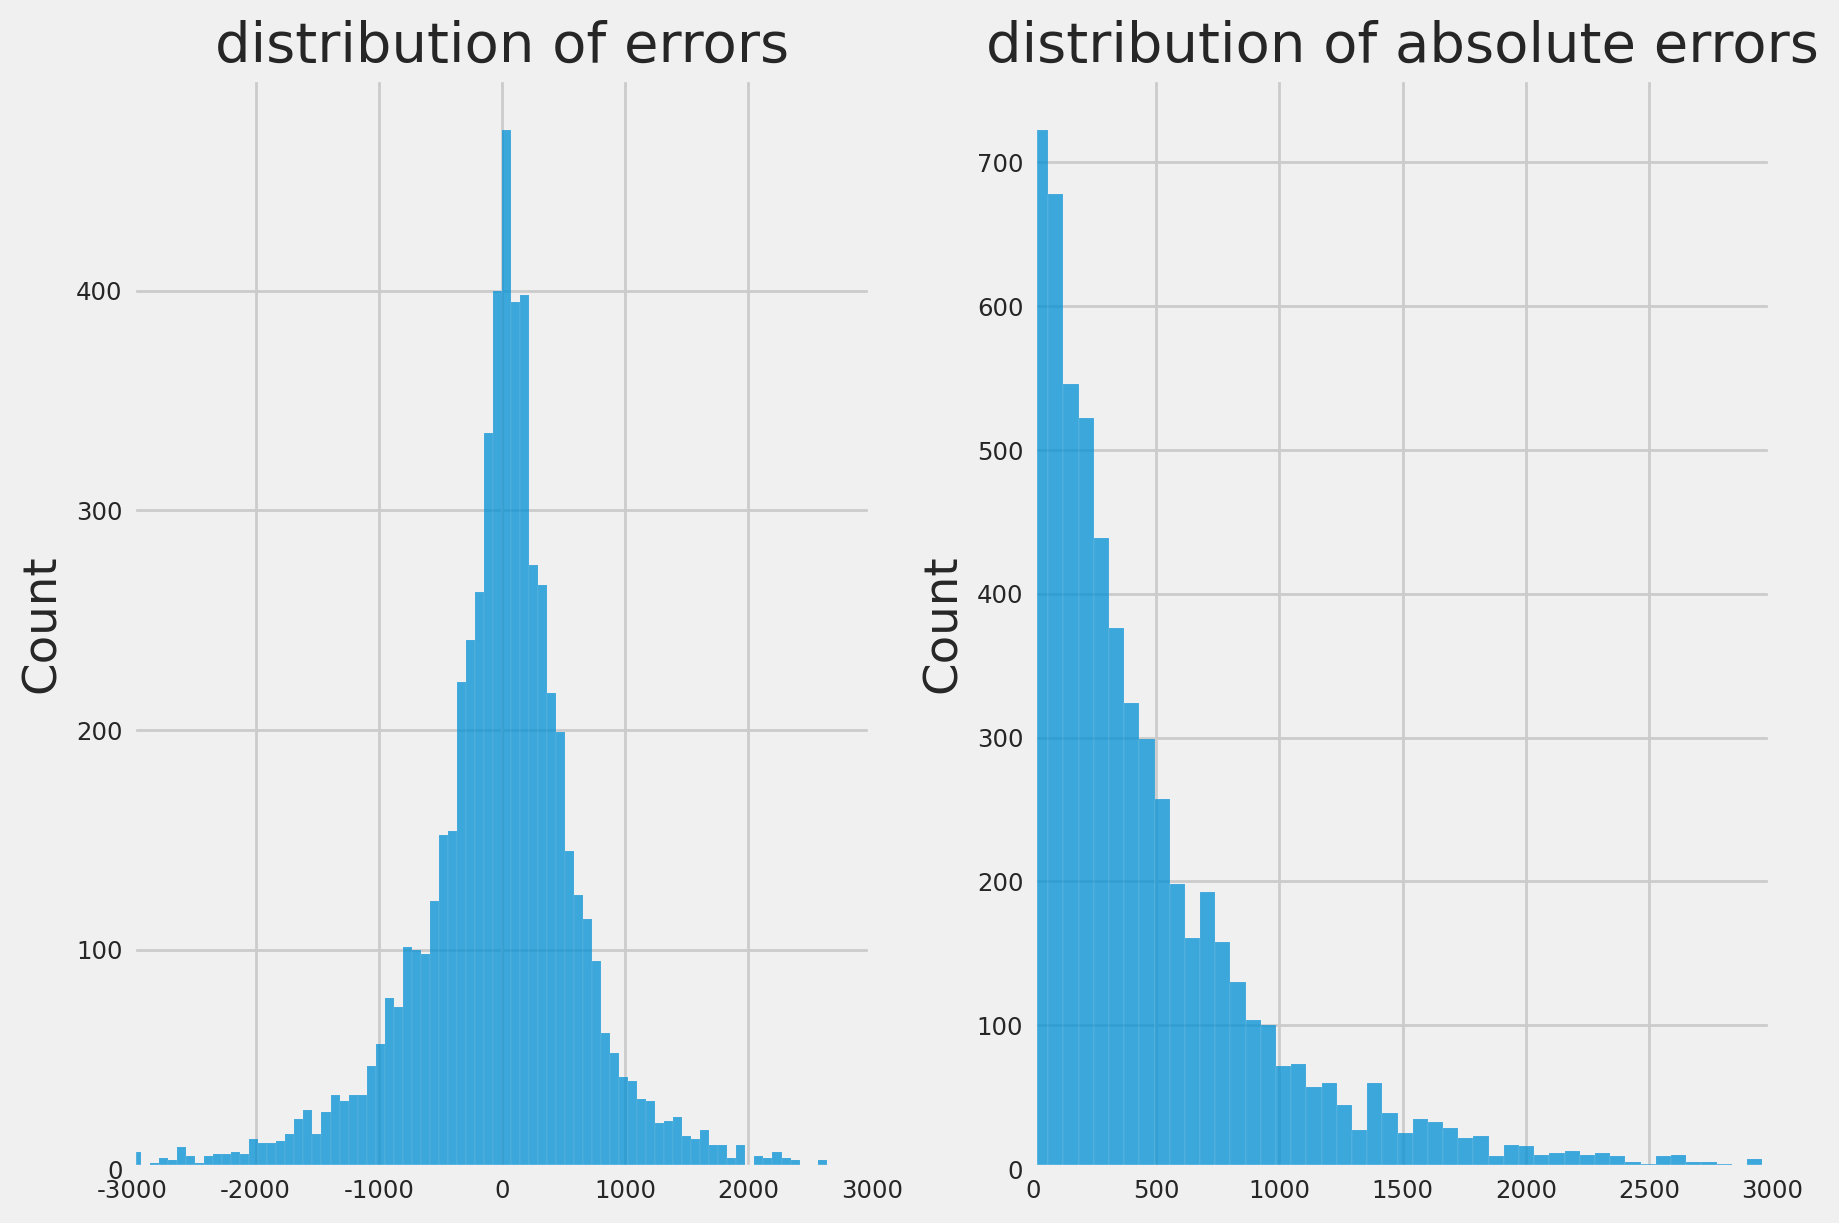

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
axes[0].set_xlim([-3000,3000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
axes[1].set_xlim([0,3000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');
pass

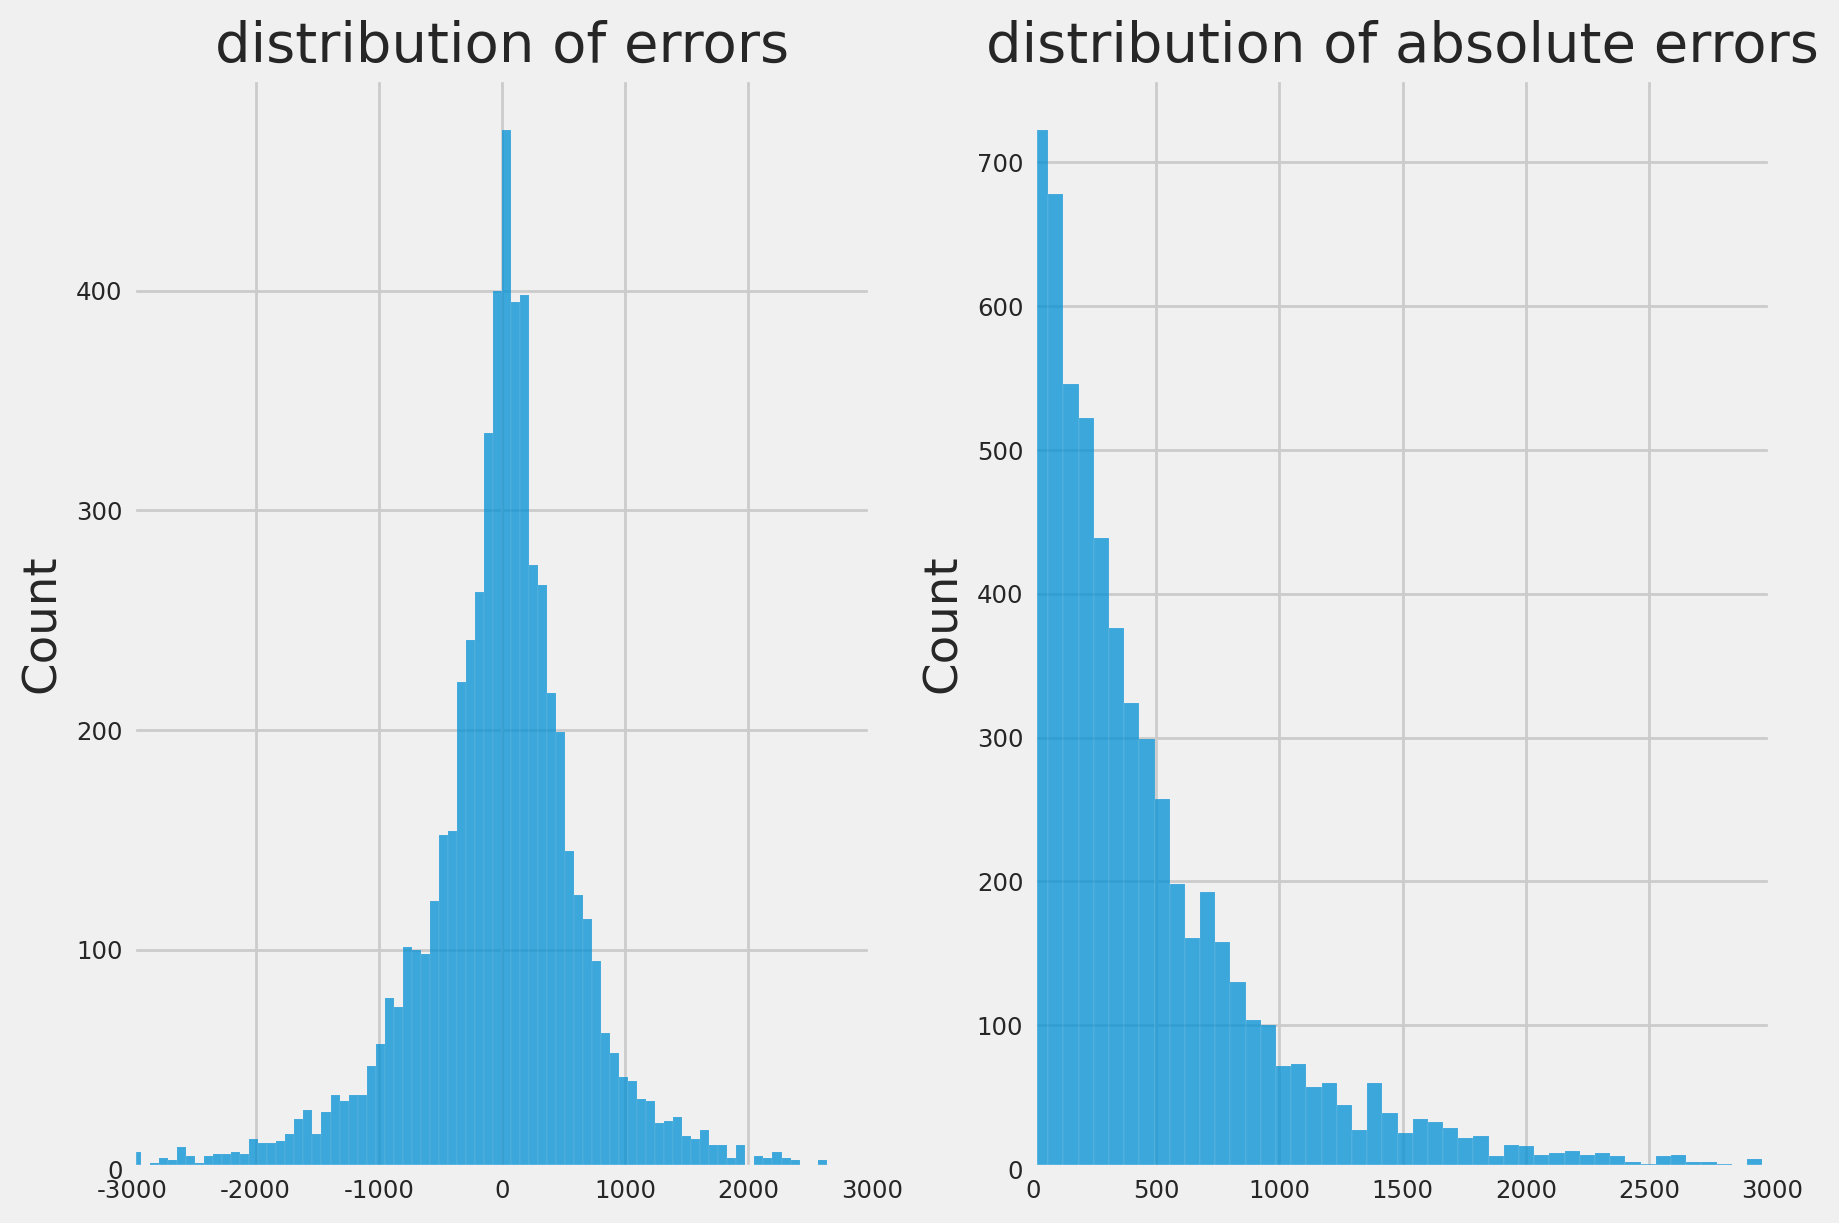

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
axes[0].set_xlim([-3000,3000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
axes[1].set_xlim([0,3000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');
pass

# 세일즈 포인트 제외

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 67)

(125474, 67)

(156843, 67)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
model_xgb = XGBRegressor(tree_method="hist", device="cuda")

In [ ]:
model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred1 = model_xgb.predict(X_train)
y_pred2 = model_xgb.predict(X_val)
y_pred3 = model_xgb.predict(X_test)

In [ ]:
dict_data = {
    'train':{'X':X_train,'y':y_train},
    'val':{'X':X_val,'y':y_val},
    'test':{'X':X_test,'y':y_test},
}
dict_rslt = {
    'train':y_pred1,
    'val':y_pred2,
    'test':y_pred3,
}


In [ ]:
reg_score_dict = make_reg_score_entire(dict_data,dict_rslt,print_rslt=True)

train
r2 score : 0.96072
rmse_model : 747.25862 / rmse_base : 3770.41936	 mape_model : 0.08139 / mape_base : 0.35823	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.95528
rmse_model : 796.33872 / rmse_base : 3765.52438	 mape_model : 0.08224 / mape_base : 0.35857	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.95312
rmse_model : 811.29022 / rmse_base : 3747.06972	 mape_model : 0.08259 / mape_base : 0.36010	
------------------------------------------------------------------------------------------------------------------------------------------------------


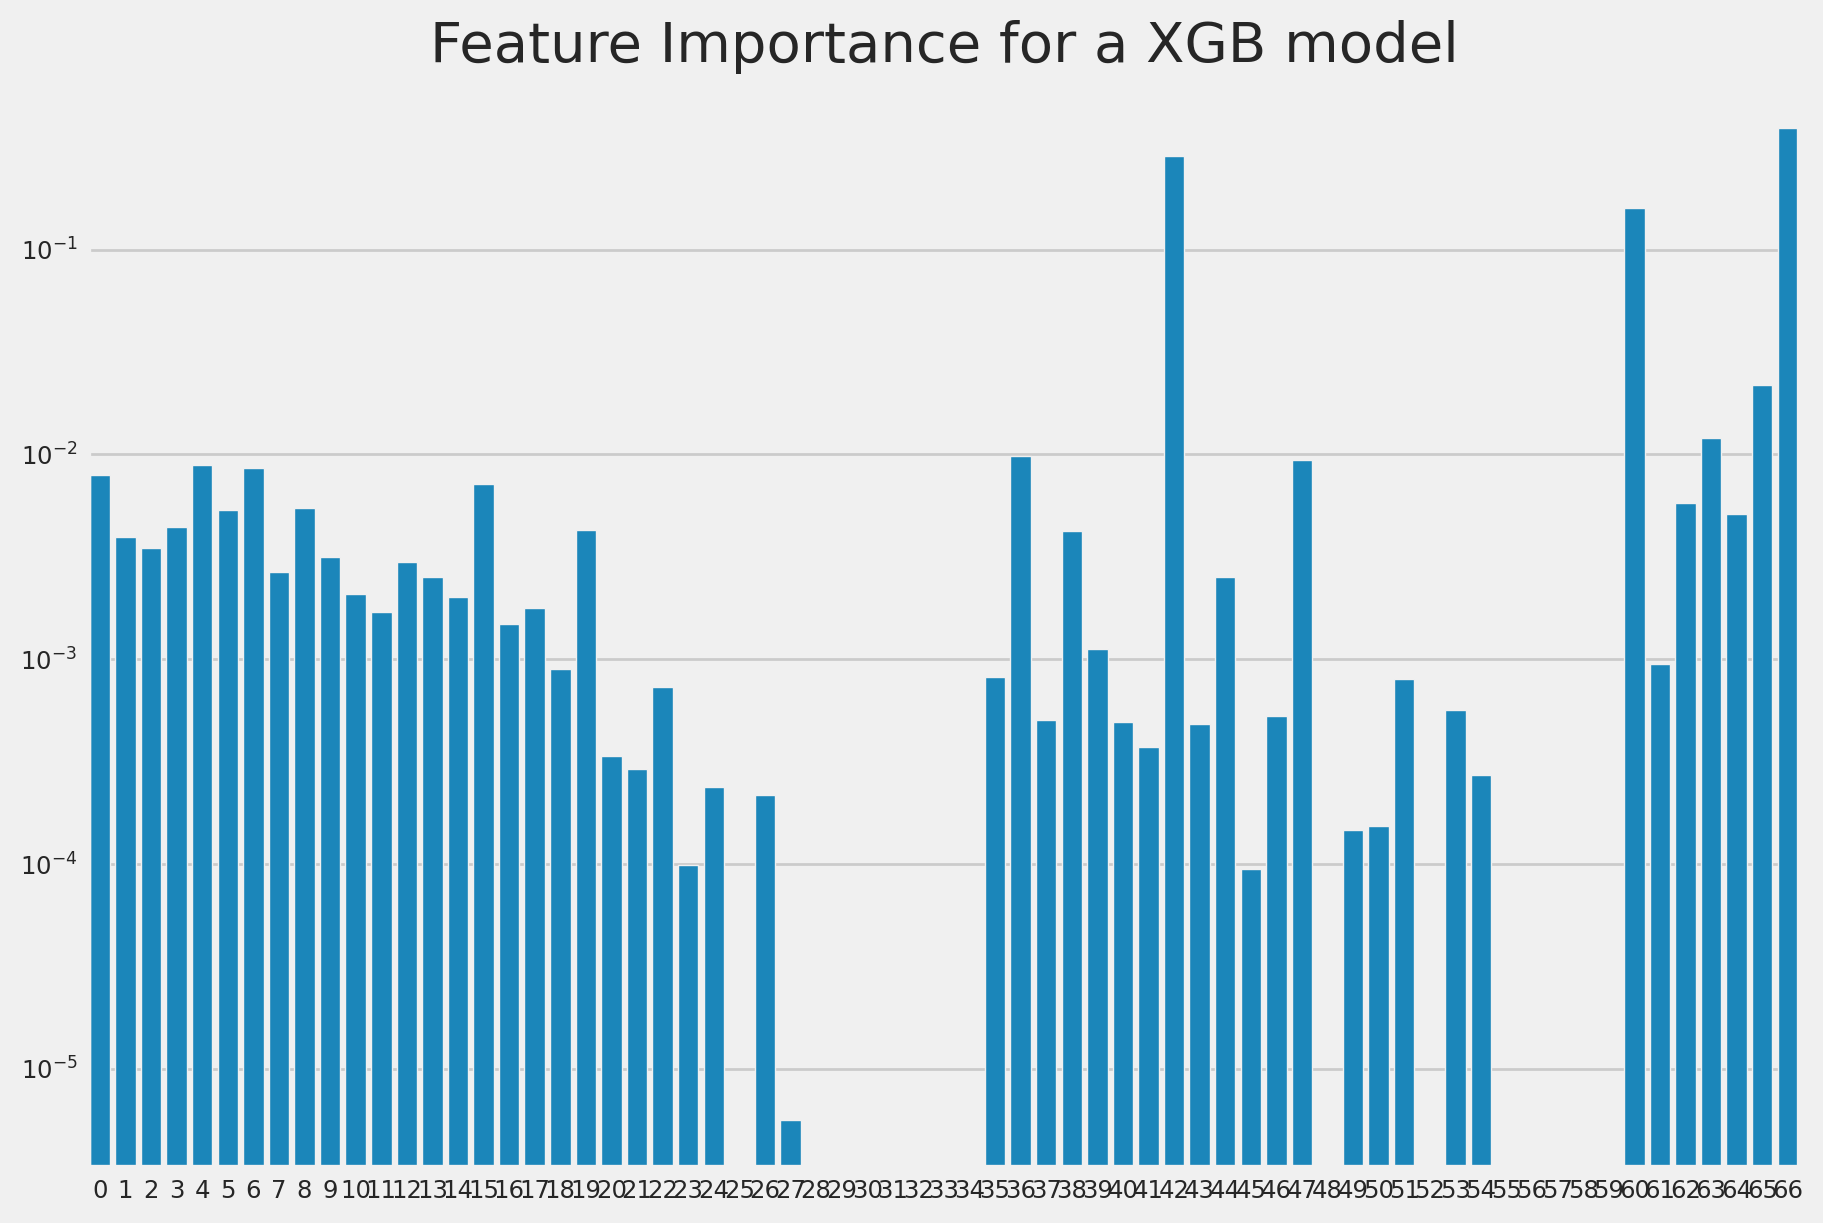

In [ ]:
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(model_xgb.feature_importances_,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a XGB model')
#ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
pass

In [ ]:
crop=True
crop_idx=[-1]

In [ ]:
col_vector = ['Category','BName','BName_sub']

In [ ]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

[7]


['quality', 'store', 'Author', 'Author_mul', 'Publshr', 'Pdate', 'RglPrice']

In [ ]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]

In [ ]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
fi_model =model_xgb.feature_importances_
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.028612468,
  'BName': 0.05391098,
  'BName_sub': 0.31893322,
  'quality': 0.1600396,
  'store': 0.0009482201,
  'Author': 0.0057525877,
  'Author_mul': 0.012028431,
  'Publshr': 0.005106742,
  'Pdate': 0.021758659,
  'RglPrice': 0.39290908},
 0.9999999879510142)

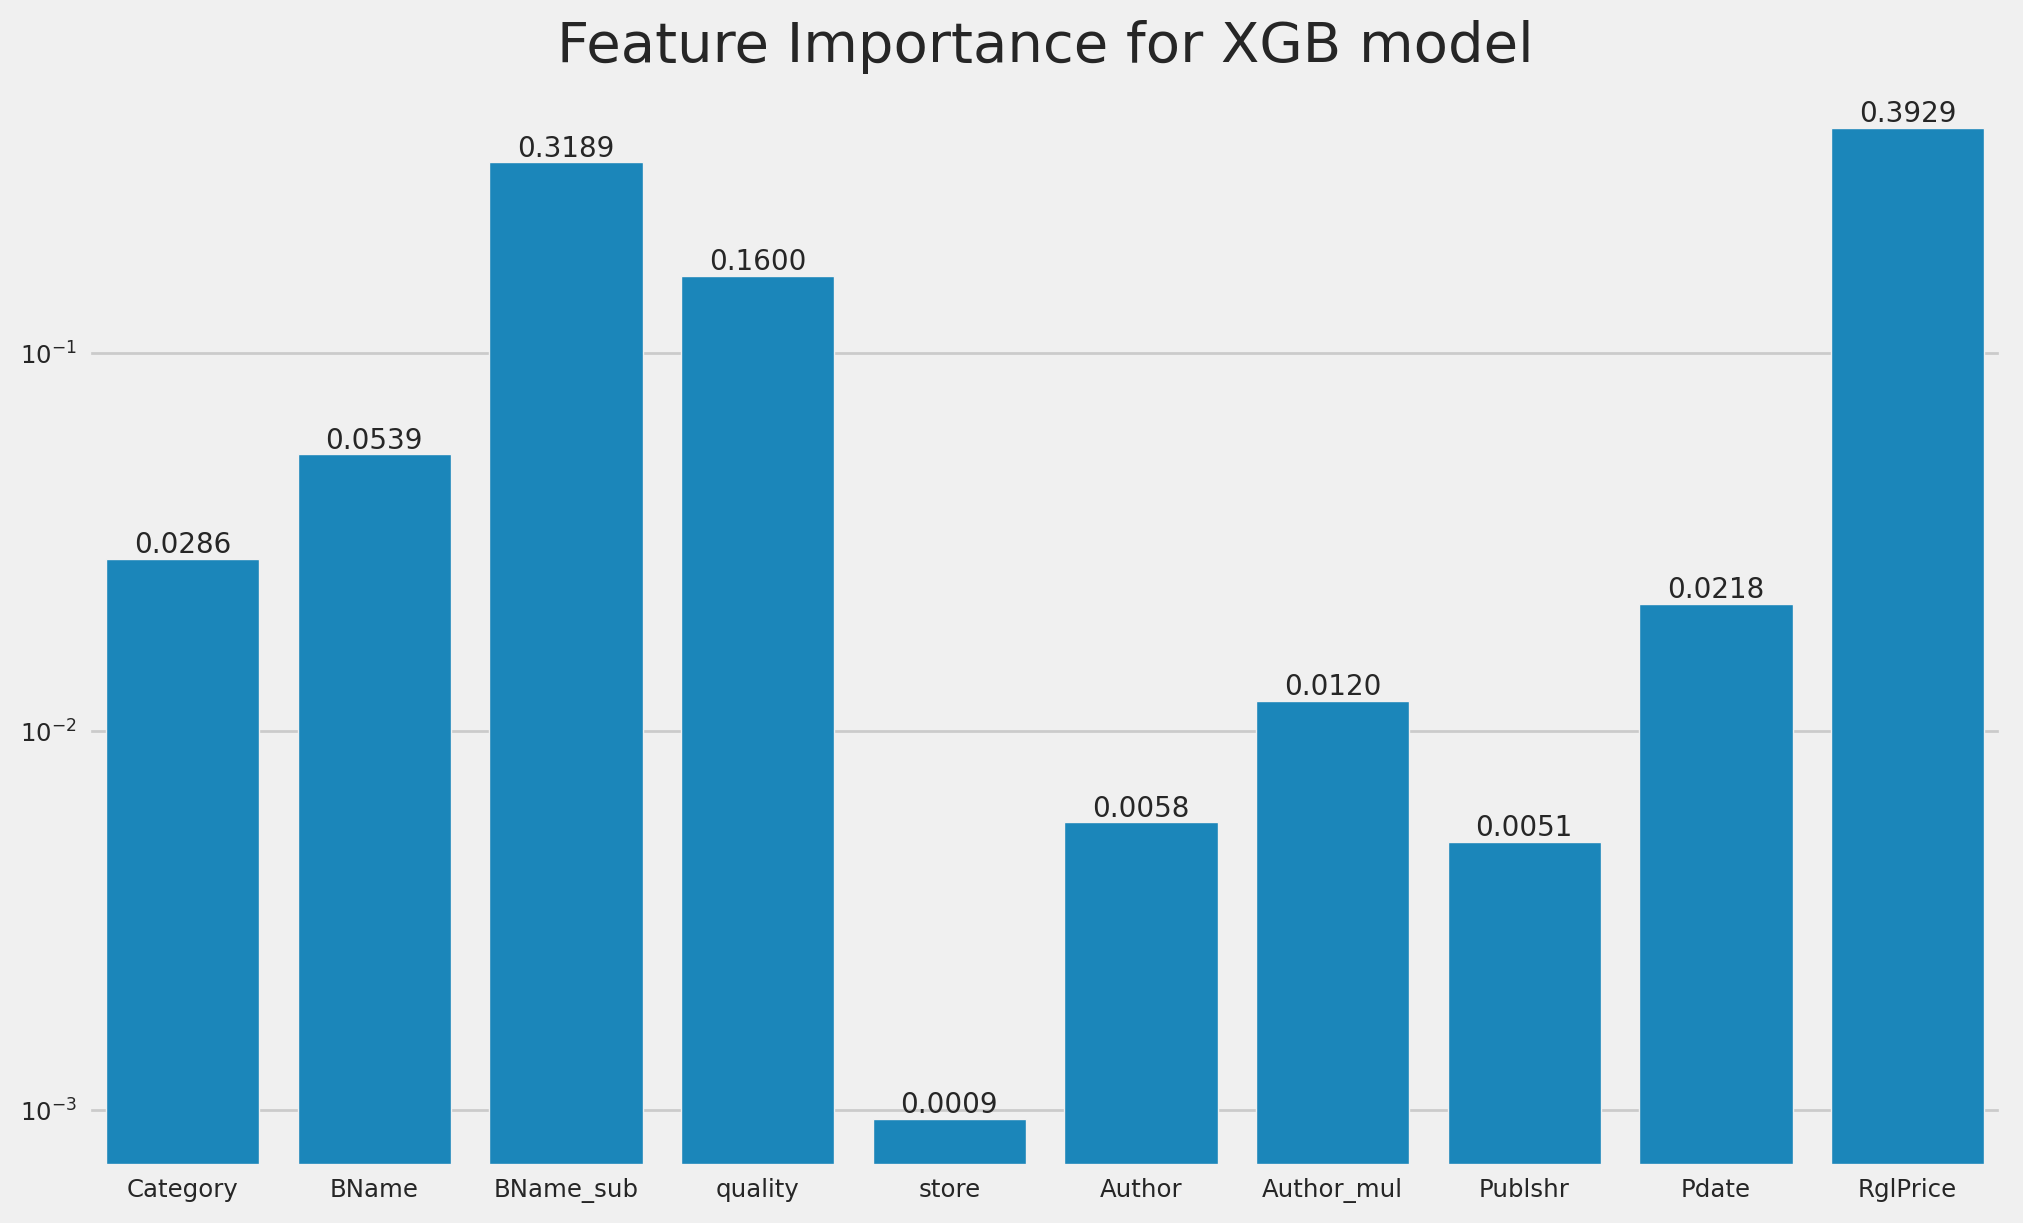

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for XGB model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

In [ ]:
model_xgb_best1 = XGBRegressor(tree_method="hist",
  colsample_bytree= 1,
  device= 'cuda',
  learning_rate= 0.5,
  max_depth= 5,
  n_estimators= 2100)

In [ ]:
model_xgb_best2 = XGBRegressor(tree_method="hist",
  colsample_bytree= 0.5,
  device= 'cuda',
  learning_rate= 0.5,
  max_depth= 5,
  n_estimators= 2100)

In [ ]:
model_xgb_best1.fit(X_train,y_train)
model_xgb_best2.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred11 = model_xgb_best1.predict(X_train)
y_pred12 = model_xgb_best1.predict(X_val)
y_pred13 = model_xgb_best1.predict(X_test)

y_pred21 = model_xgb_best2.predict(X_train)
y_pred22 = model_xgb_best2.predict(X_val)
y_pred23 = model_xgb_best2.predict(X_test)

In [ ]:
dict_rslt_best1 = {
    'train':y_pred11,
    'val':y_pred12,
    'test':y_pred13,
}

dict_rslt_best2 = {
    'train':y_pred21,
    'val':y_pred22,
    'test':y_pred23,
}

In [ ]:
reg_score_dict_best1 = make_reg_score_entire(dict_data,dict_rslt_best1,print_rslt=True)
reg_score_dict_best2 = make_reg_score_entire(dict_data,dict_rslt_best2,print_rslt=True)

train
r2 score : 0.98410
rmse_model : 475.36398 / rmse_base : 3770.41936	 mape_model : 0.05658 / mape_base : 0.35823	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.96929
rmse_model : 659.88795 / rmse_base : 3765.52438	 mape_model : 0.06647 / mape_base : 0.35857	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.97047
rmse_model : 643.86659 / rmse_base : 3747.06972	 mape_model : 0.06653 / mape_base : 0.36010	
------------------------------------------------------------------------------------------------------------------------------------------------------
train
r2 score : 0.98228
rmse_model : 501.91797 / rmse_base : 3770.41936	 mape_model : 0.06015 / mape_base : 0.35823	
------------------------------------------------------------------------------

(<Figure size 1500x1200 with 12 Axes>,
 array([[<Axes: title={'left': 'train:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 475.364 | rmse_base : 3770.419\nr2 score : 0.984                                       n = 501896\n', ylabel='count'>,
         <Axes: title={'center': 'model score'}>],
        [<Axes: title={'left': 'val:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 659.888 | rmse_base : 3765.524\nr2 score : 0.969                                       n = 125474\n', ylabel='count'>,
         <Axes: title={'center': 'model score'}>],
        [<Axes: title={'left': 'test:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 643.867 | rmse_base : 3747.070\nr2 score : 0.970                                       n = 156843\n', ylabel='count'>,
         <Axes: title={'c

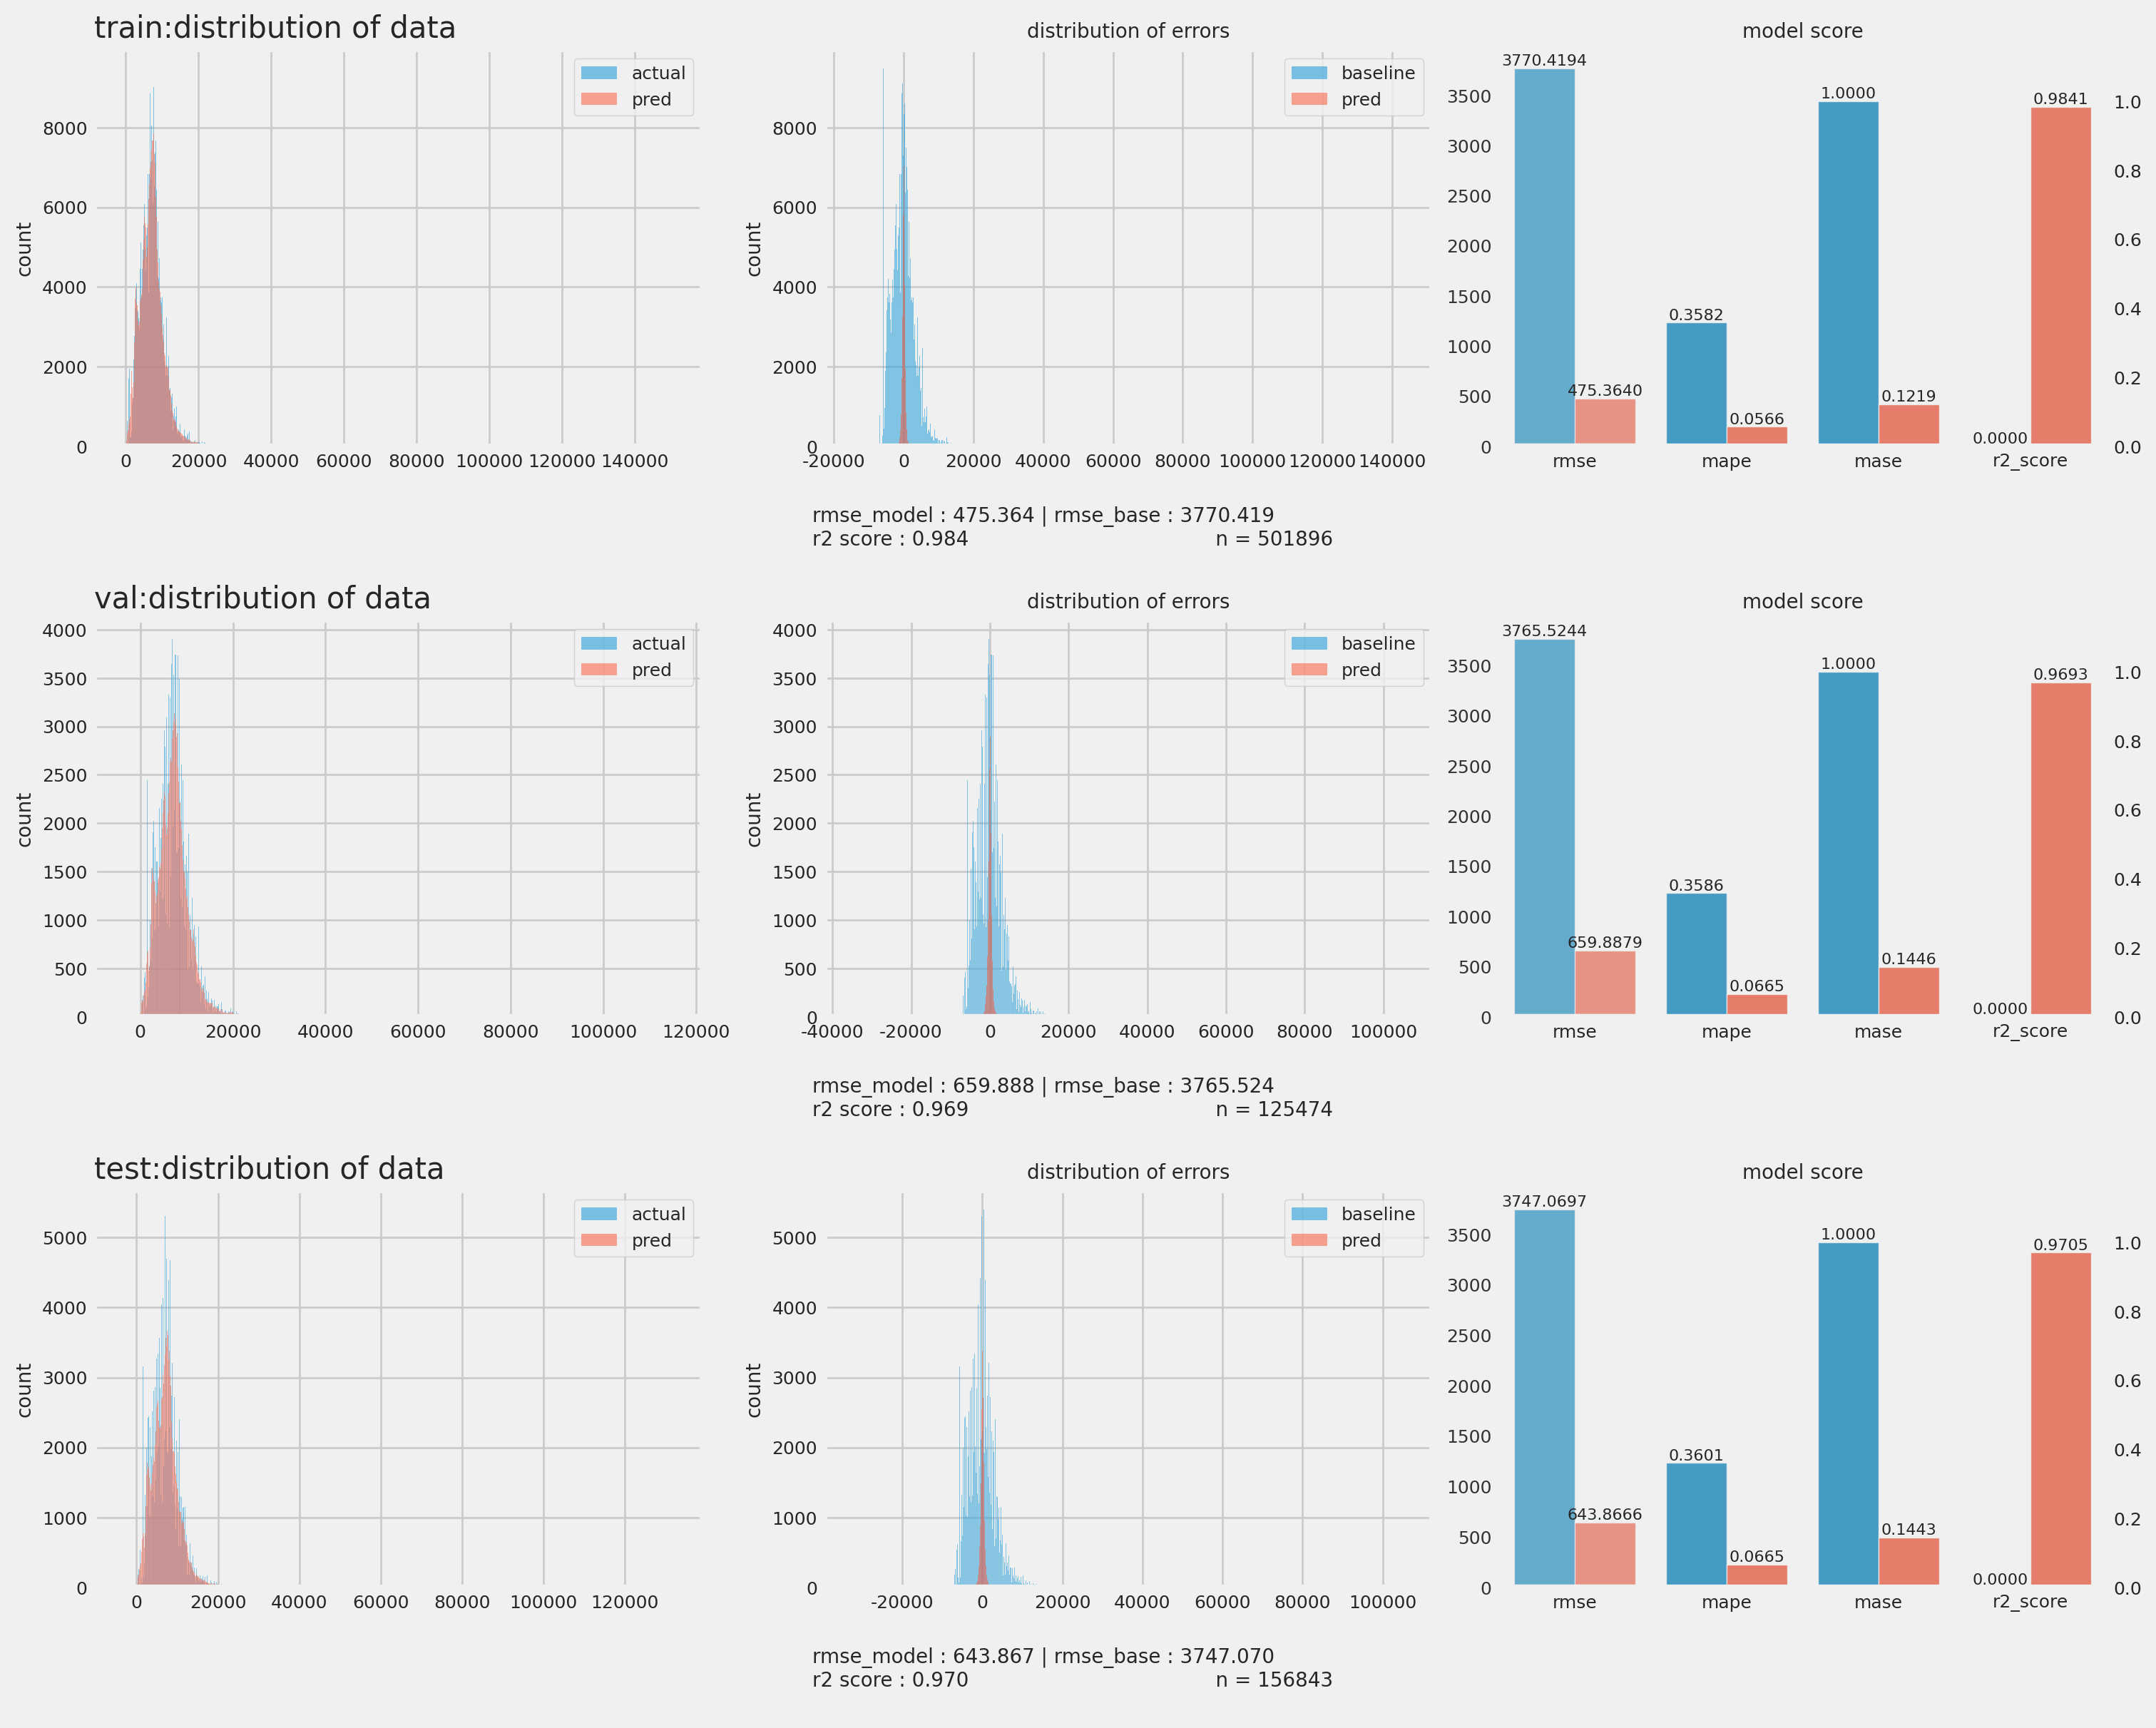

In [ ]:
plot_reg_score(dict_data,dict_rslt_best1,reg_score_dict_best1)

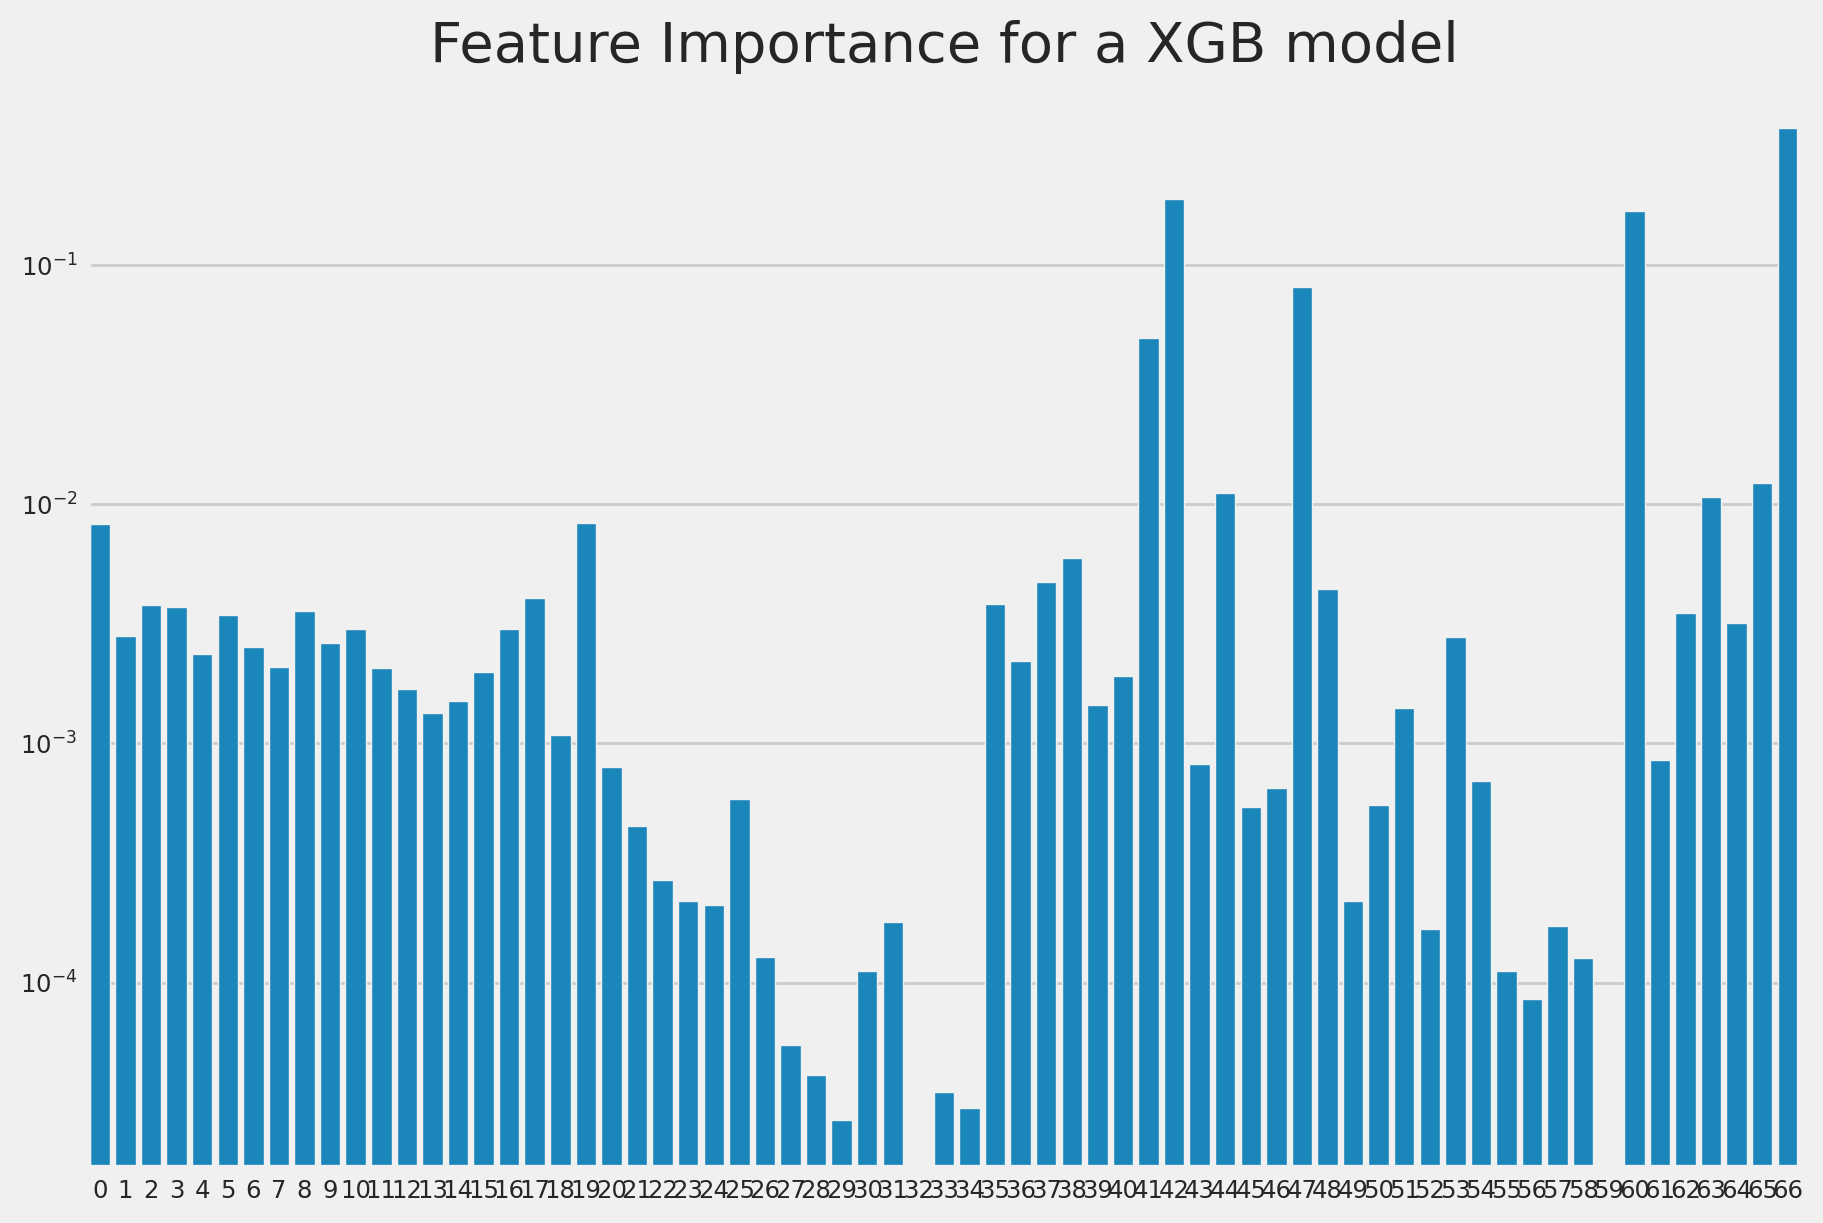

In [ ]:
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(model_xgb_best1.feature_importances_,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a XGB model')
#ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
pass

In [ ]:
crop, crop_idx

(True, [-1])

In [ ]:
col_vector = ['Category','BName','BName_sub']

In [ ]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

[7]


['quality', 'store', 'Author', 'Author_mul', 'Publshr', 'Pdate', 'RglPrice']

In [ ]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
col_partition

[(0, 5),
 (5, 35),
 (35, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (64, 65),
 (65, 66),
 (66, 67)]

In [ ]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
fi_model =model_xgb_best1.feature_importances_
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.02086539,
  'BName': 0.045432758,
  'BName_sub': 0.3624426,
  'quality': 0.16771057,
  'store': 0.0008482374,
  'Author': 0.0035153688,
  'Author_mul': 0.010653852,
  'Publshr': 0.0031703727,
  'Pdate': 0.0122877555,
  'RglPrice': 0.37307304},
 0.9999999601859599)

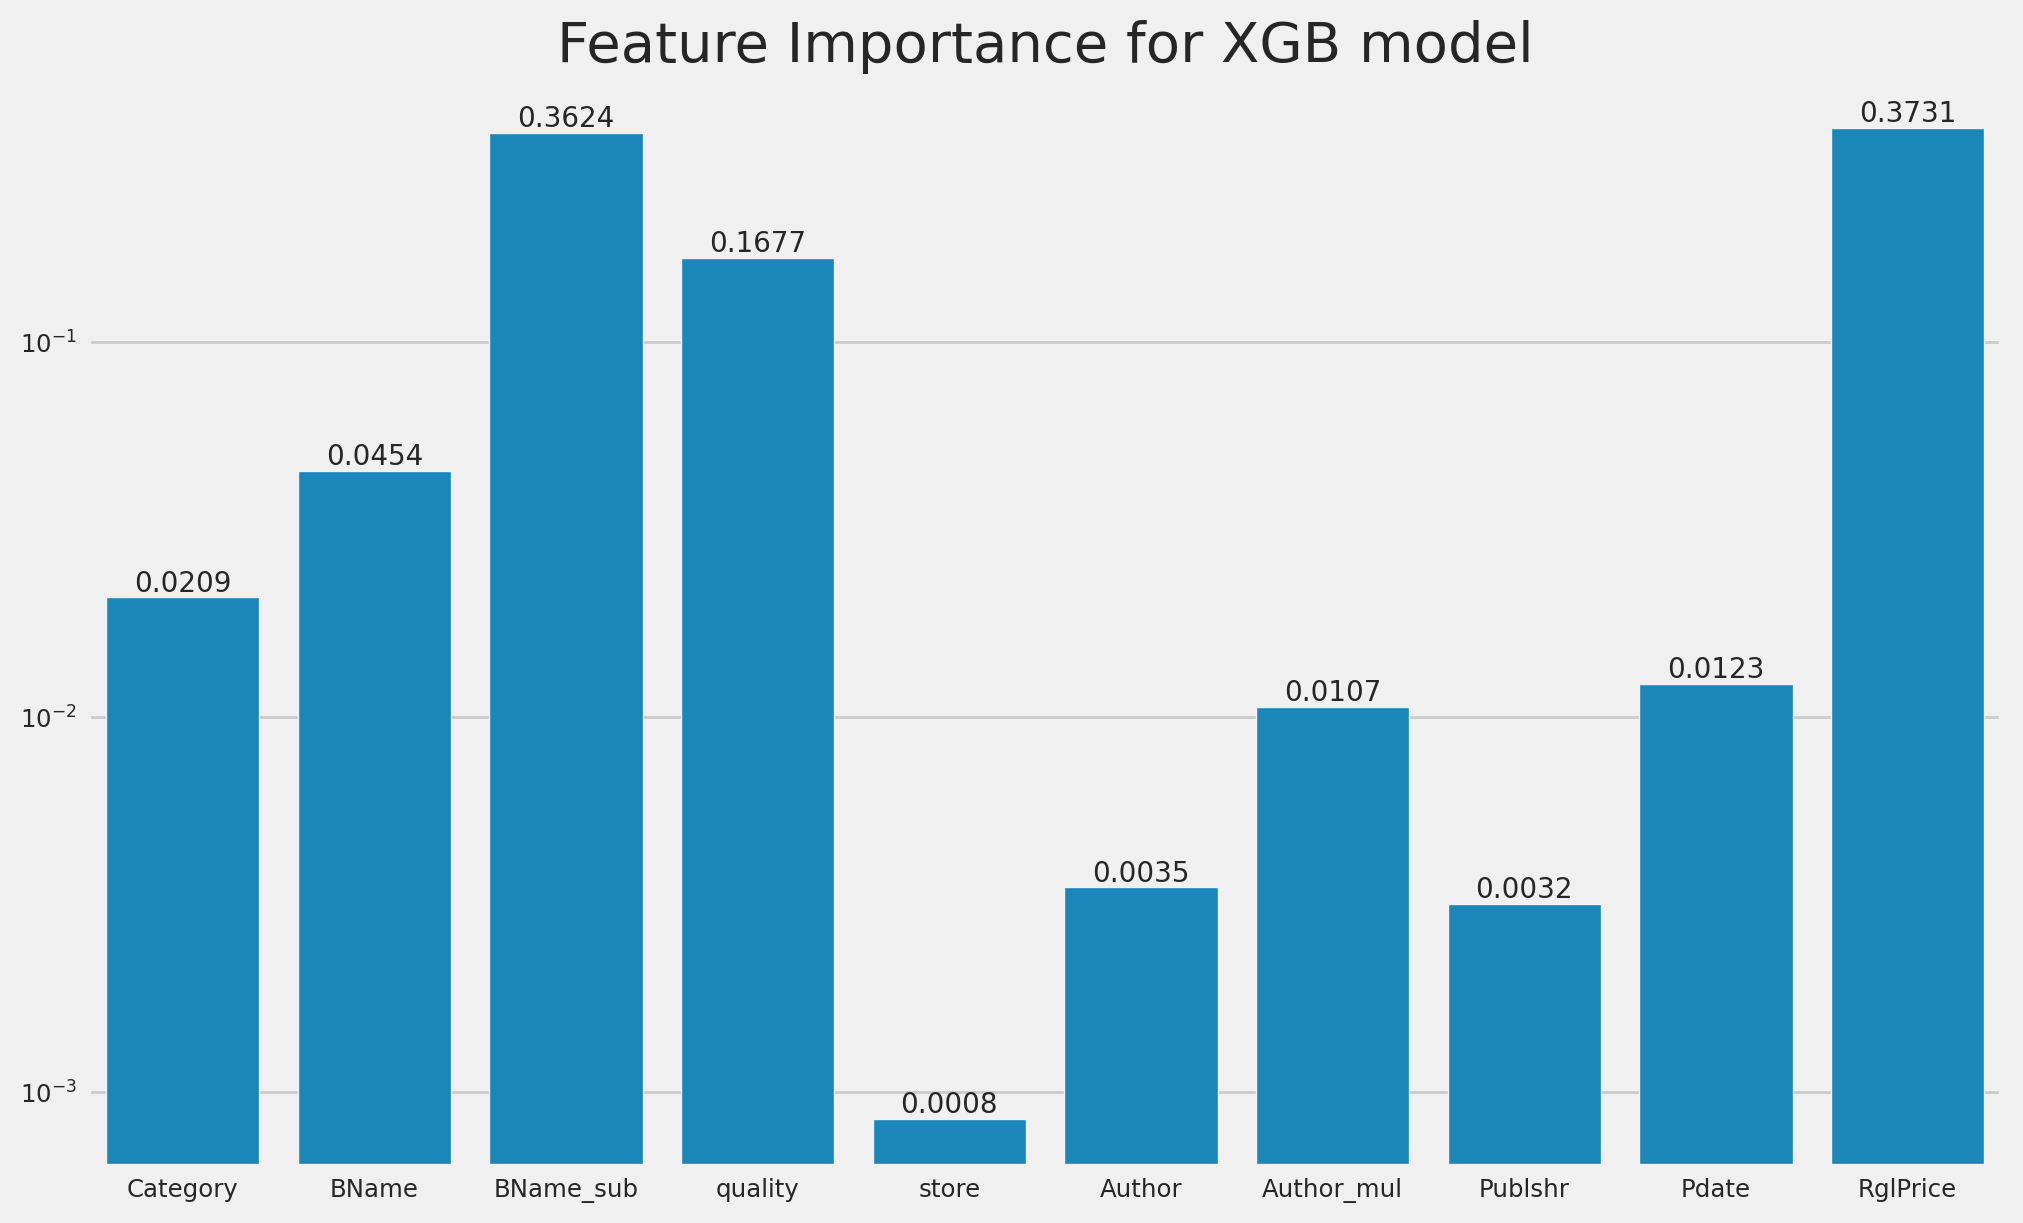

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for XGB model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

- 만약 ItemId가 포함되지 않은 것들로 test set을 추리면 어떻게 될까

In [ ]:
#RSLT_DIR = PRJCT_PATH + 'processed/'
RSLT_DIR = './'
ver, strat = 1.0, False
file_name = 'data_splitted_ver{}_strat-{}.pkl'.format(ver,strat)
file_path = os.path.join(RSLT_DIR,file_name)
data = load_pkl(file_path)

file_name = 'bookinfo_ver{}.csv'.format(1.0)
file_path = os.path.join(RSLT_DIR,file_name)
bookinfo = pd.read_csv(file_path)

items=dict()
for mode,sample in data.items():
    items[mode]= set(sample['X']['ItemId'].values)

In [ ]:
display(len(items['val'].difference(items['train'])))
display(len(items['test'].difference(items['train'])))


4084

4984

In [ ]:
res_val = list(items['val'].difference(items['train']))
res_test = list(items['test'].difference(items['train']))
res_items = res_val+res_test
len(res_items)

9068

In [ ]:
cond_val_res = data['val']['X']['ItemId'].isin(res_val).to_numpy()
cond_test_res = data['test']['X']['ItemId'].isin(res_val).to_numpy()
display(np.sum(cond_val_res))
display(np.sum(cond_test_res))

4677

1451

In [ ]:
len(cond_val_res), len(cond_test_res)

(125474, 156843)

In [ ]:
len(y_val[cond_val_res]),len(y_test[cond_test_res])

(4677, 1451)

In [ ]:
X_res = np.vstack((X_val[cond_val_res],X_test[cond_test_res]))
y_res = np.hstack((y_val[cond_val_res],y_test[cond_test_res]))
X_res.shape, y_res.shape

((6128, 67), (6128,))

In [ ]:
pred4 = model_xgb.predict(X_res)
pred14 = model_xgb_best1.predict(X_res)
pred24 = model_xgb_best2.predict(X_res)

In [ ]:
print("default model")
display(make_reg_score_dict(y_res,pred4,np.mean(y_train)))
print("\nbest model")
display(make_reg_score_dict(y_res,pred14,np.mean(y_train)))
print("\nbest model2")
display(make_reg_score_dict(y_res,pred24,np.mean(y_train)))

default model


{'rmse': [1498.0684190674135, 4837.522729624746],
 'mape': [0.14549781704583506, 0.5005390315845578],
 'mase': [0.17923423449085288, 1],
 'r2_score': [0.9014589593910493, 0]}


best model


{'rmse': [1719.0635612353456, 4837.522729624746],
 'mape': [0.16811154872659806, 0.5005390315845578],
 'mase': [0.19875381256424965, 1],
 'r2_score': [0.8702409323895569, 0]}


best model2


{'rmse': [1987.1287963061395, 4837.522729624746],
 'mape': [0.17372178290570692, 0.5005390315845578],
 'mase': [0.21089958694570826, 1],
 'r2_score': [0.8266172525185098, 0]}

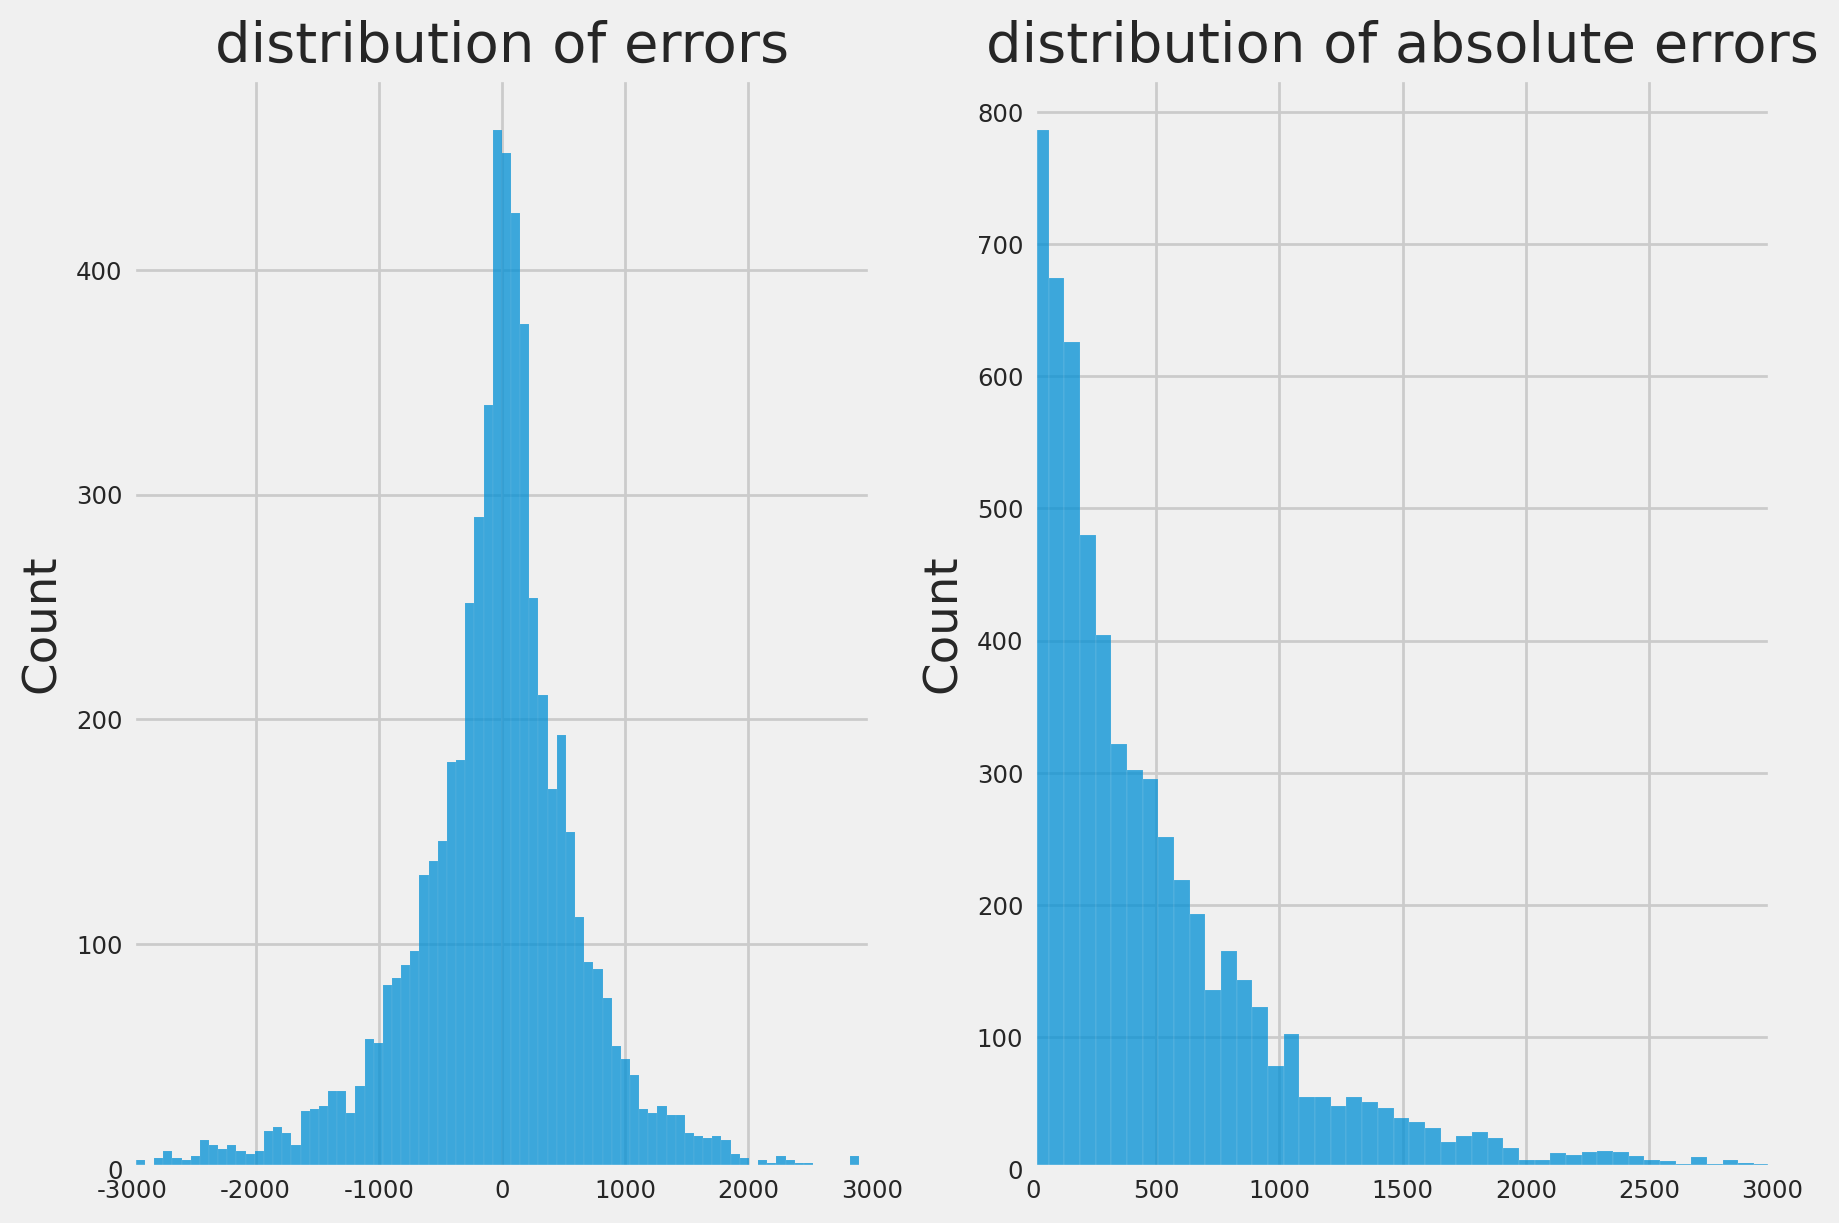

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
axes[0].set_xlim([-3000,3000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
axes[1].set_xlim([0,3000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');
pass

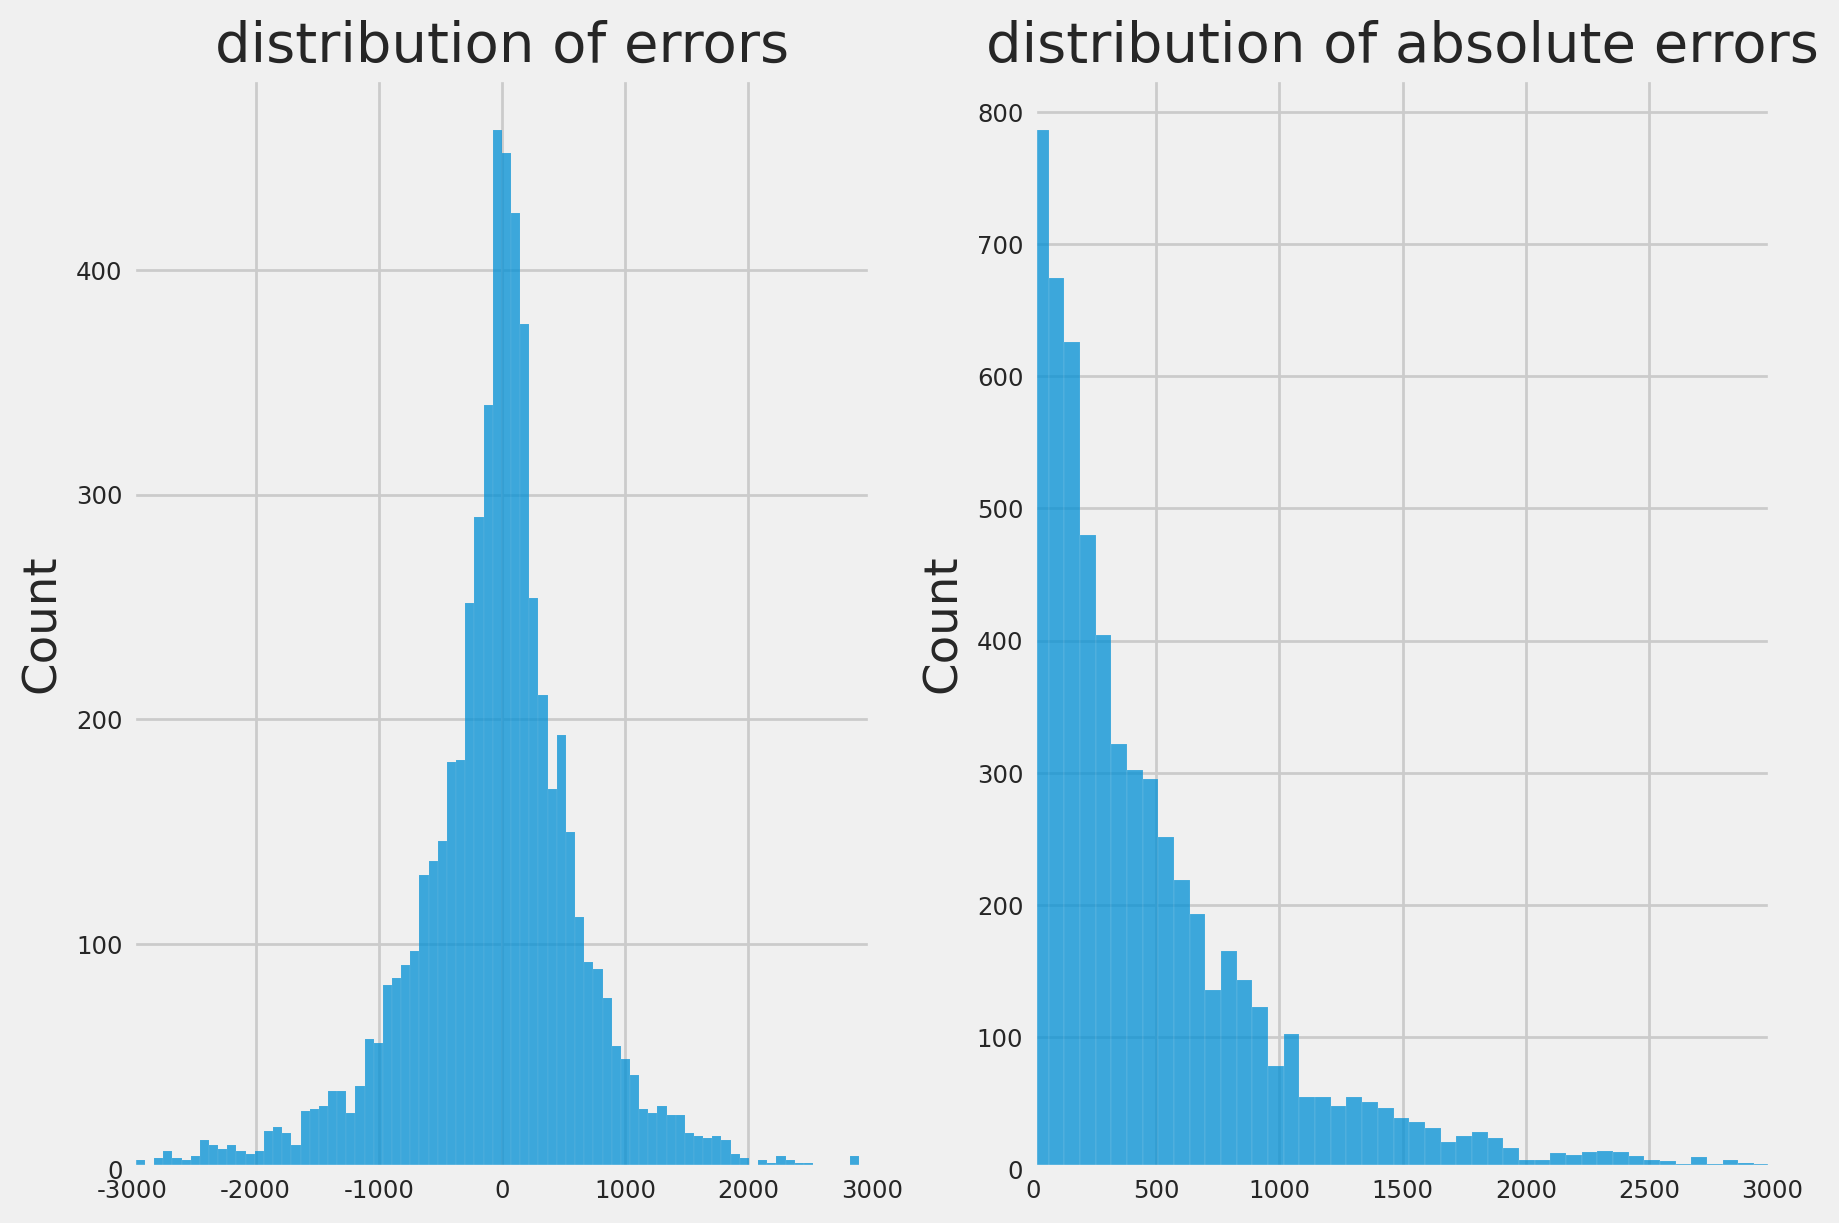

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
axes[0].set_xlim([-3000,3000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
axes[1].set_xlim([0,3000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');
pass

# 세일즈 포인트 및 정가 제외

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
#crop,crop_idx = True,[-1]
crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67, 66]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 66)

(125474, 66)

(156843, 66)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
model_xgb = XGBRegressor(tree_method="hist", device="cuda")

In [ ]:
model_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred1 = model_xgb.predict(X_train)
y_pred2 = model_xgb.predict(X_val)
y_pred3 = model_xgb.predict(X_test)

In [ ]:
dict_data = {
    'train':{'X':X_train,'y':y_train},
    'val':{'X':X_val,'y':y_val},
    'test':{'X':X_test,'y':y_test},
}
dict_rslt = {
    'train':y_pred1,
    'val':y_pred2,
    'test':y_pred3,
}


In [ ]:
reg_score_dict = make_reg_score_entire(dict_data,dict_rslt,print_rslt=True)

train
r2 score : 0.74228
rmse_model : 1914.09210 / rmse_base : 3770.41936	 mape_model : 0.19435 / mape_base : 0.35823	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.72198
rmse_model : 1985.47579 / rmse_base : 3765.52438	 mape_model : 0.19880 / mape_base : 0.35857	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.72113
rmse_model : 1978.74679 / rmse_base : 3747.06972	 mape_model : 0.19860 / mape_base : 0.36010	
------------------------------------------------------------------------------------------------------------------------------------------------------


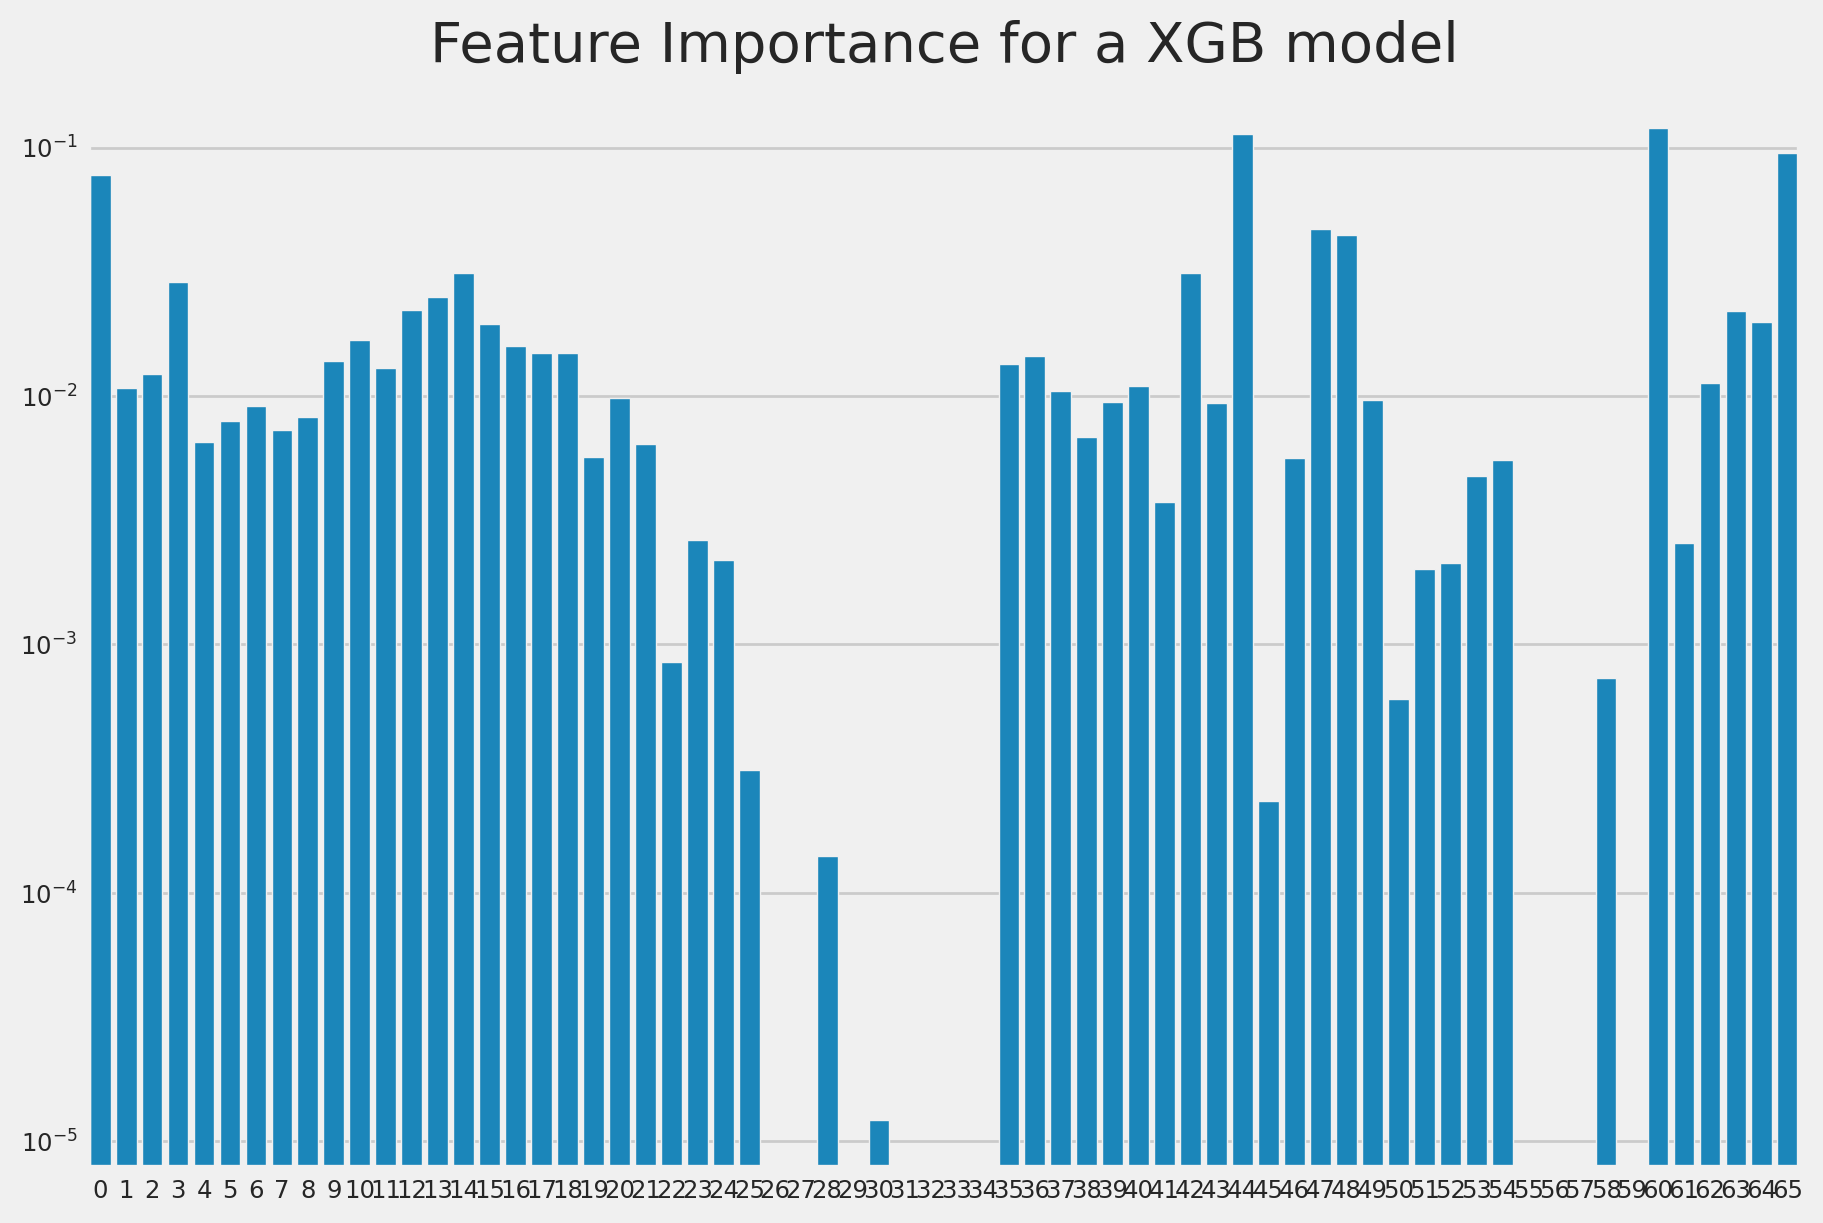

In [ ]:
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(model_xgb.feature_importances_,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a XGB model')
#ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
pass

In [ ]:
crop=True
crop_idx=[-1,-2]

In [ ]:
col_vector = ['Category','BName','BName_sub']

In [ ]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

[7, 6]


['quality', 'store', 'Author', 'Author_mul', 'Publshr', 'Pdate']

In [ ]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]

In [ ]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
fi_model =model_xgb.feature_importances_
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.13549587,
  'BName': 0.2479849,
  'BName_sub': 0.34566832,
  'quality': 0.12006587,
  'store': 0.0025613045,
  'Author': 0.011313919,
  'Author_mul': 0.021893576,
  'Publshr': 0.019897416,
  'Pdate': 0.095118806},
 0.9999999774154276)

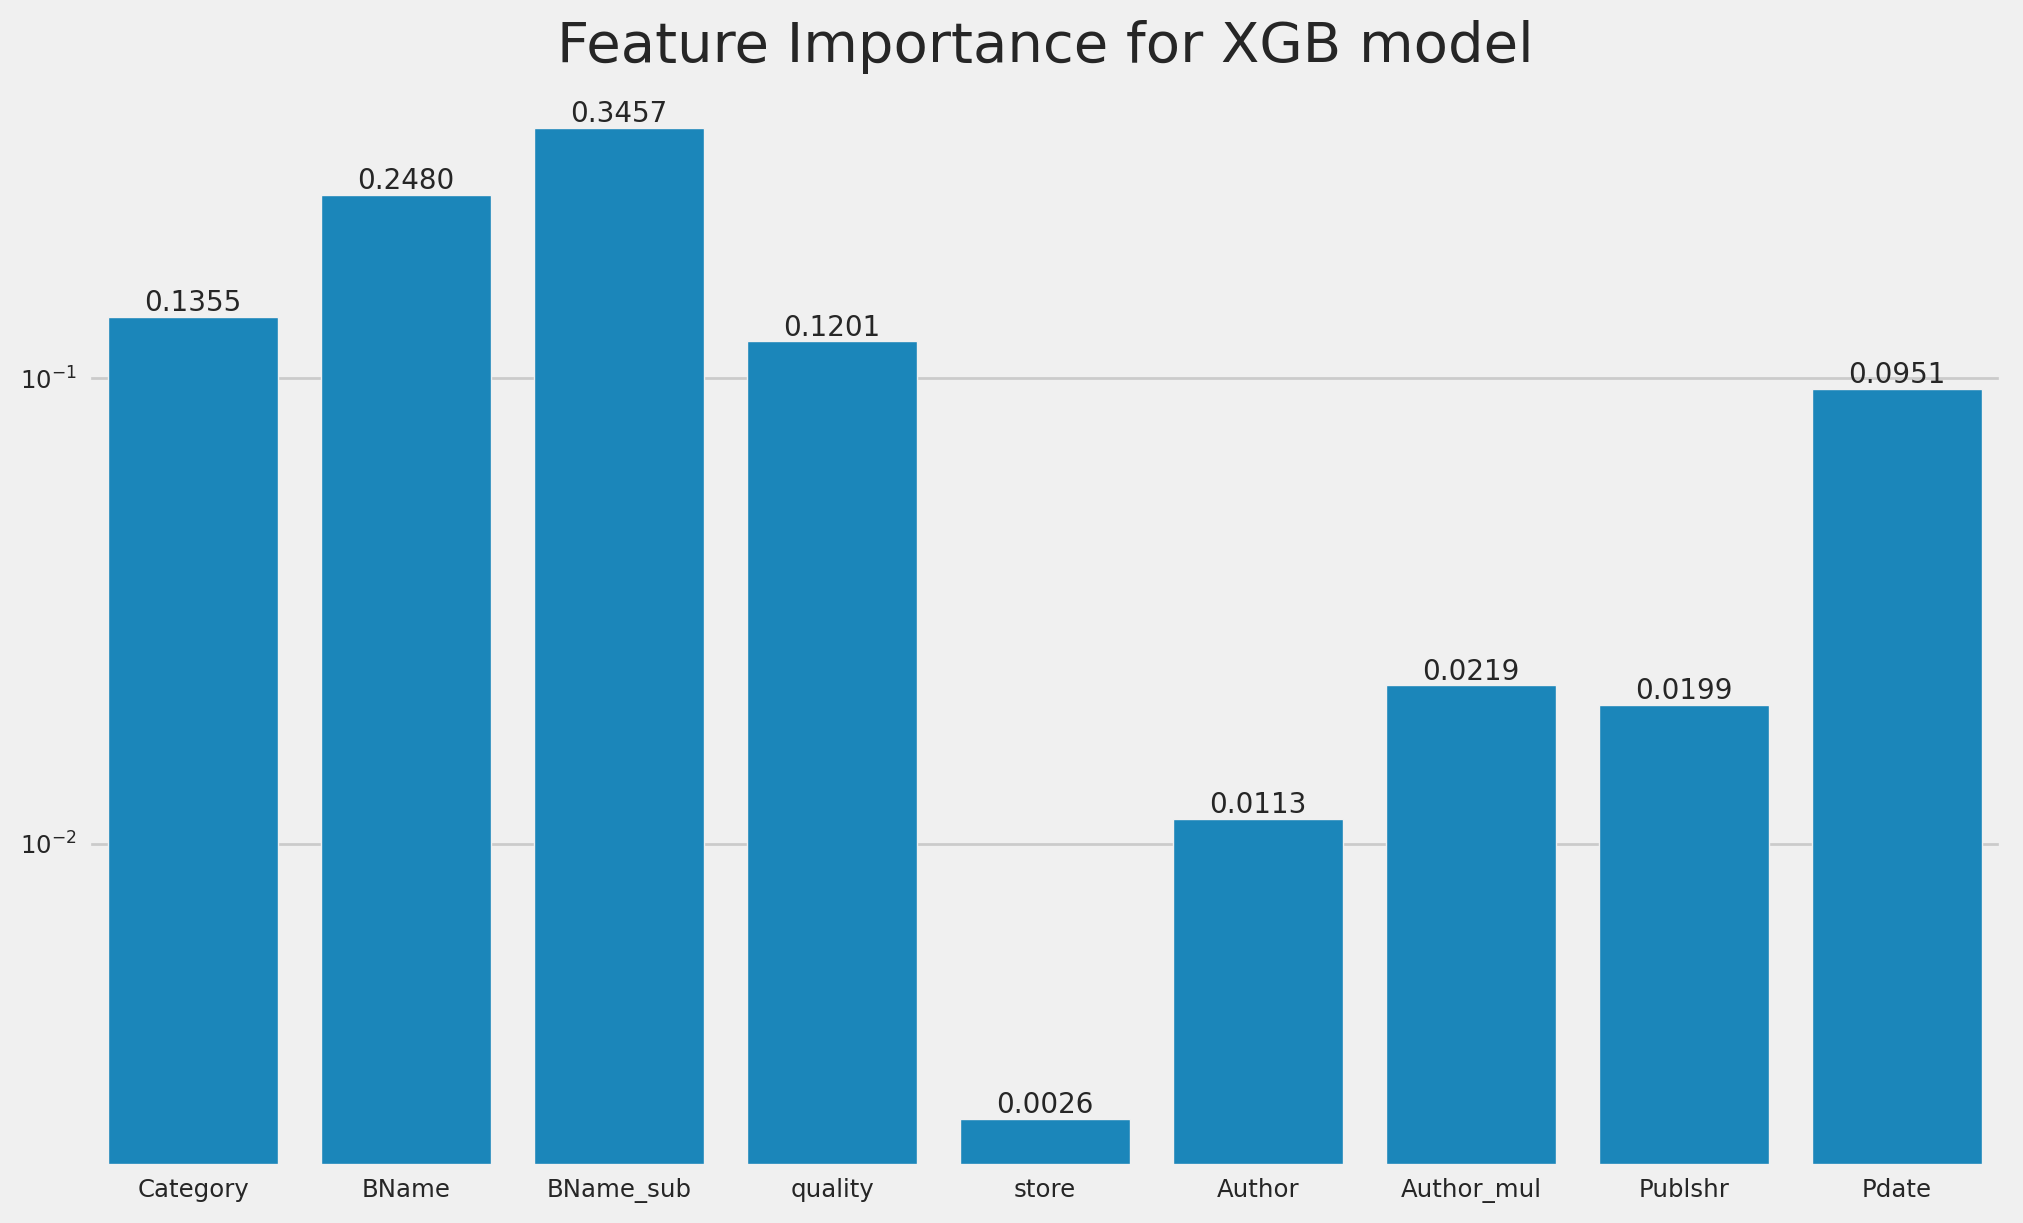

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for XGB model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

In [ ]:
model_xgb_best1 = XGBRegressor(tree_method="hist",
  colsample_bytree= 1,
  device= 'cuda',
  learning_rate= 0.5,
  max_depth= 5,
  n_estimators= 2100)

In [ ]:
model_xgb_best2 = XGBRegressor(tree_method="hist",
  colsample_bytree= 0.5,
  device= 'cuda',
  learning_rate= 0.5,
  max_depth= 5,
  n_estimators= 2100)

In [ ]:
model_xgb_best1.fit(X_train,y_train)
model_xgb_best2.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred11 = model_xgb_best1.predict(X_train)
y_pred12 = model_xgb_best1.predict(X_val)
y_pred13 = model_xgb_best1.predict(X_test)

y_pred21 = model_xgb_best2.predict(X_train)
y_pred22 = model_xgb_best2.predict(X_val)
y_pred23 = model_xgb_best2.predict(X_test)

In [ ]:
dict_rslt_best1 = {
    'train':y_pred11,
    'val':y_pred12,
    'test':y_pred13,
}

dict_rslt_best2 = {
    'train':y_pred21,
    'val':y_pred22,
    'test':y_pred23,
}

In [ ]:
reg_score_dict_best1 = make_reg_score_entire(dict_data,dict_rslt_best1,print_rslt=True)
reg_score_dict_best2 = make_reg_score_entire(dict_data,dict_rslt_best2,print_rslt=True)

train
r2 score : 0.93824
rmse_model : 937.00959 / rmse_base : 3770.41936	 mape_model : 0.10822 / mape_base : 0.35823	
------------------------------------------------------------------------------------------------------------------------------------------------------
val
r2 score : 0.90071
rmse_model : 1186.54896 / rmse_base : 3765.52438	 mape_model : 0.12690 / mape_base : 0.35857	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.89803
rmse_model : 1196.53907 / rmse_base : 3747.06972	 mape_model : 0.12602 / mape_base : 0.36010	
------------------------------------------------------------------------------------------------------------------------------------------------------
train
r2 score : 0.92606
rmse_model : 1025.26050 / rmse_base : 3770.41936	 mape_model : 0.11574 / mape_base : 0.35823	
---------------------------------------------------------------------------

(<Figure size 1500x1200 with 12 Axes>,
 array([[<Axes: title={'left': 'train:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 937.010 | rmse_base : 3770.419\nr2 score : 0.938                                       n = 501896\n', ylabel='count'>,
         <Axes: title={'center': 'model score'}>],
        [<Axes: title={'left': 'val:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 1186.549 | rmse_base : 3765.524\nr2 score : 0.901                                       n = 125474\n', ylabel='count'>,
         <Axes: title={'center': 'model score'}>],
        [<Axes: title={'left': 'test:distribution of data'}, ylabel='count'>,
         <Axes: title={'center': 'distribution of errors'}, xlabel='rmse_model : 1196.539 | rmse_base : 3747.070\nr2 score : 0.898                                       n = 156843\n', ylabel='count'>,
         <Axes: title={

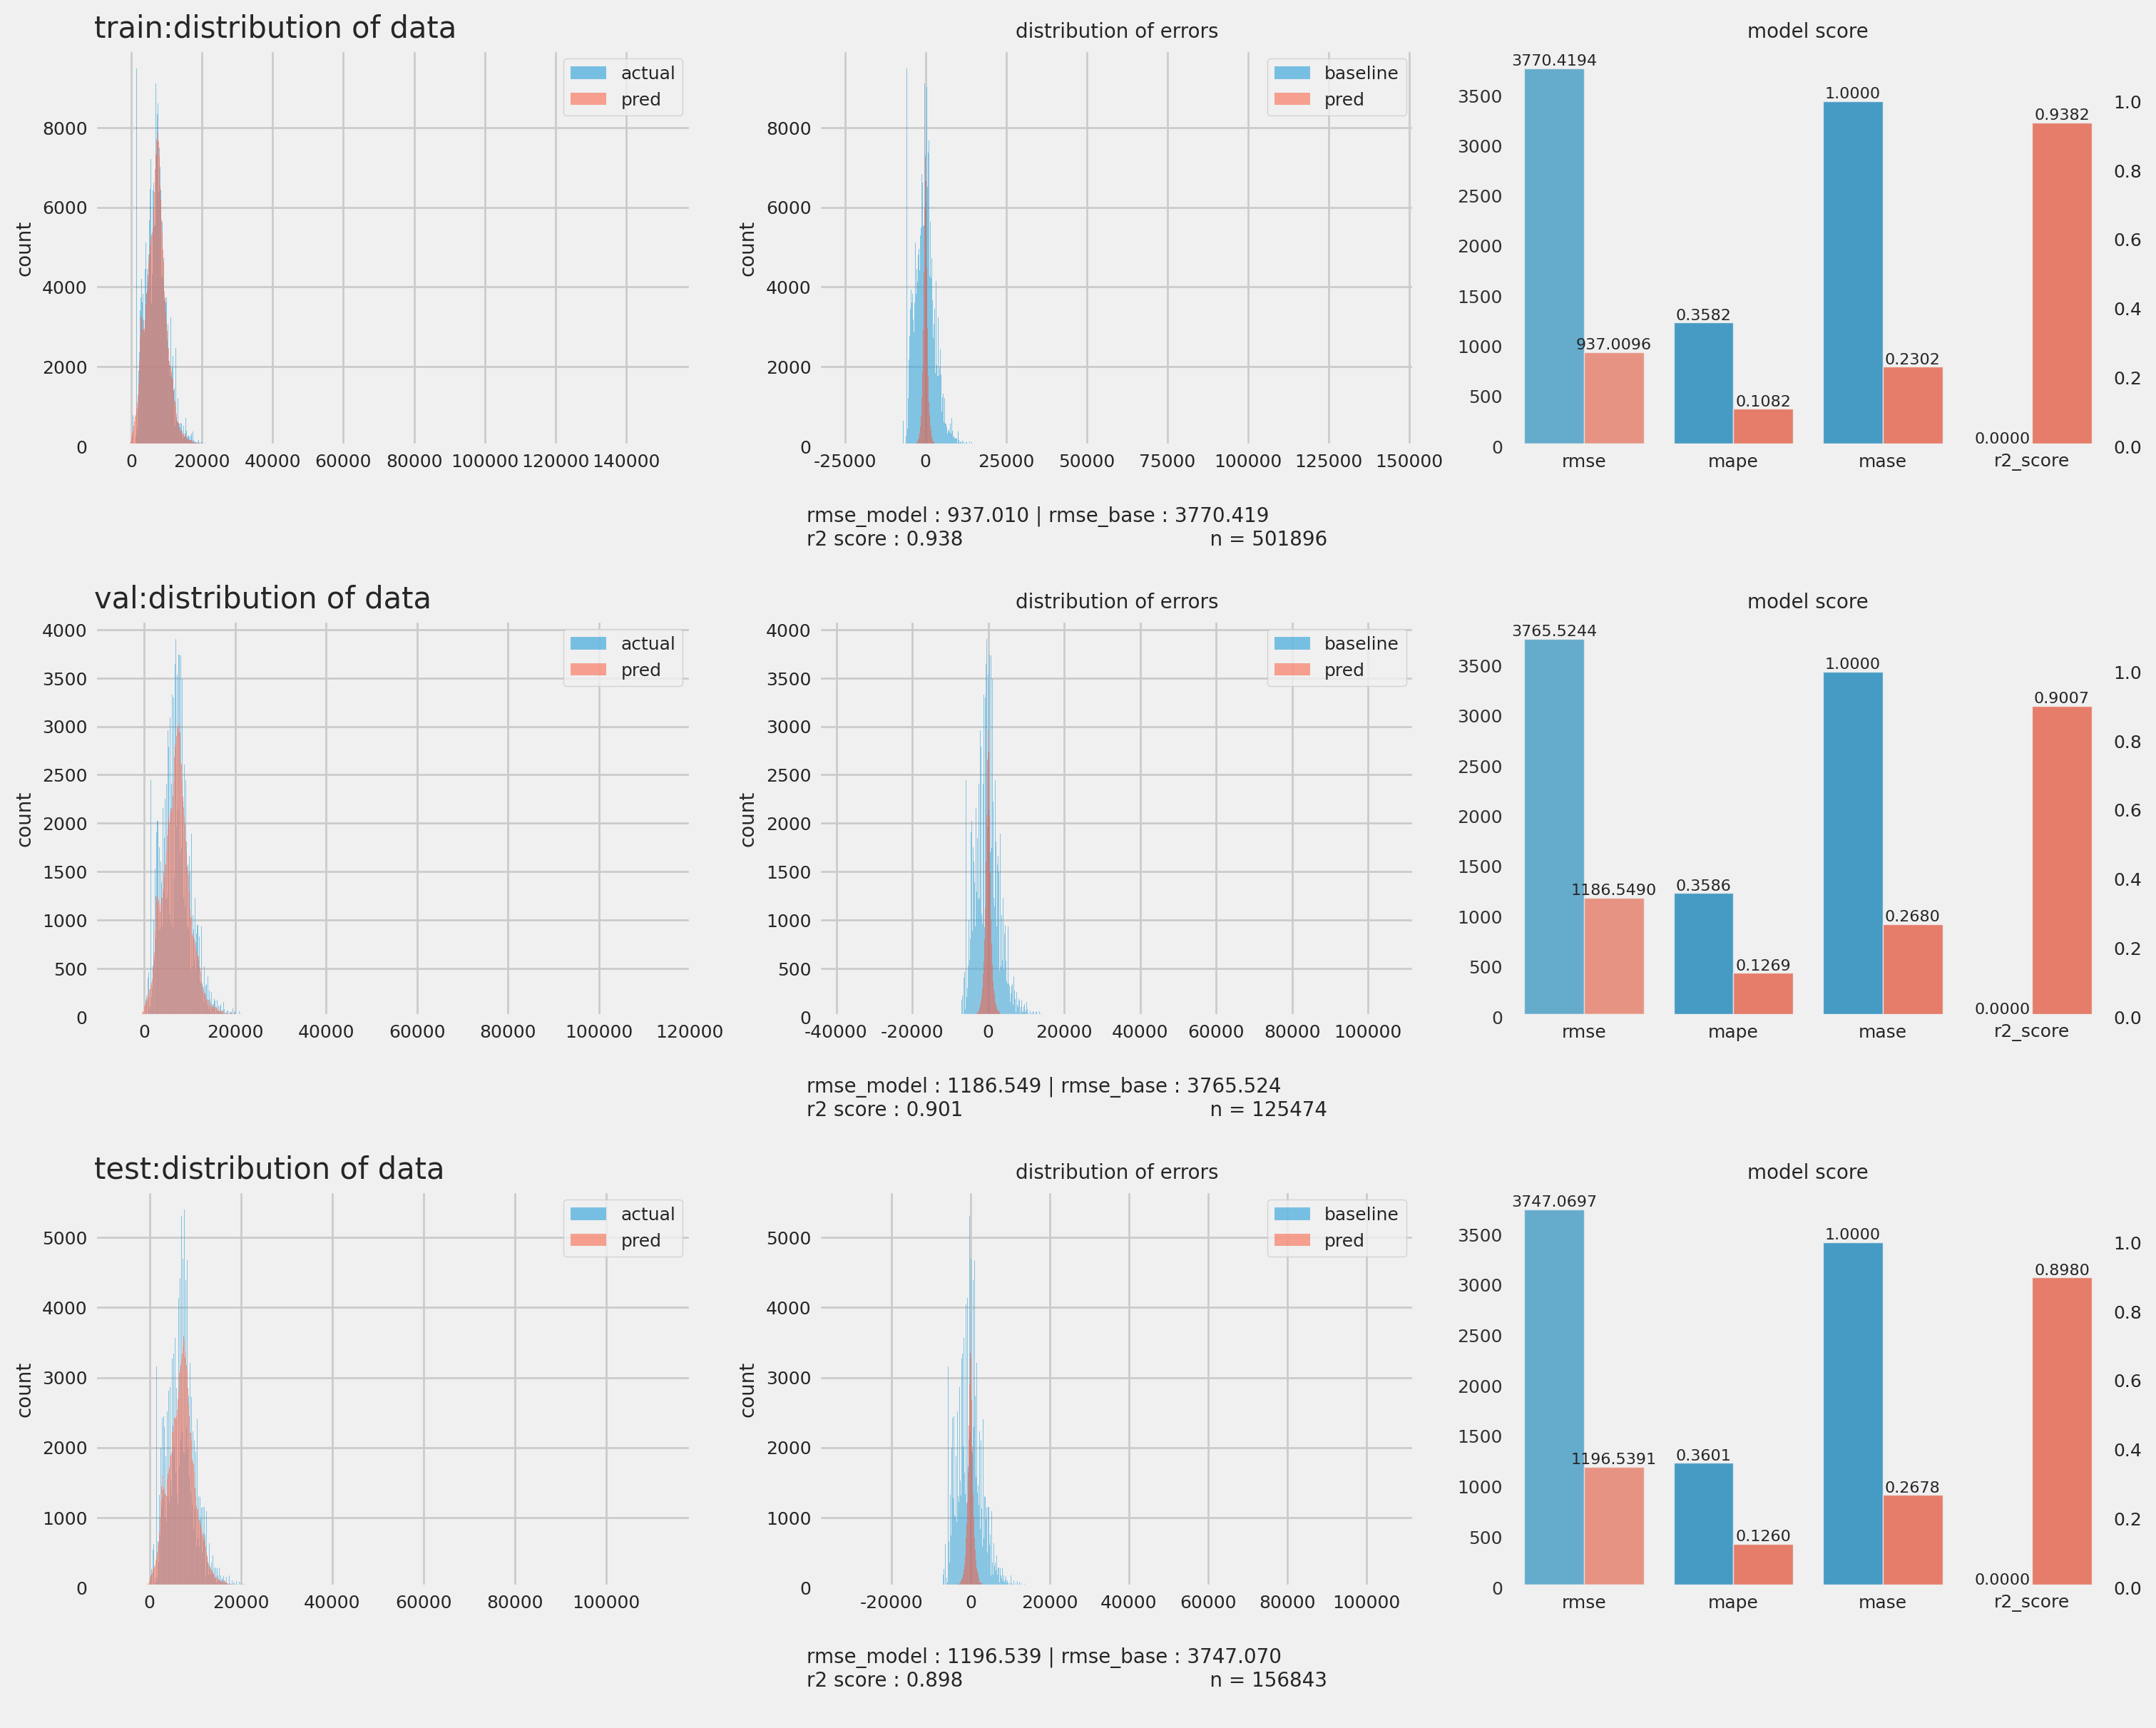

In [ ]:
plot_reg_score(dict_data,dict_rslt_best1,reg_score_dict_best1)

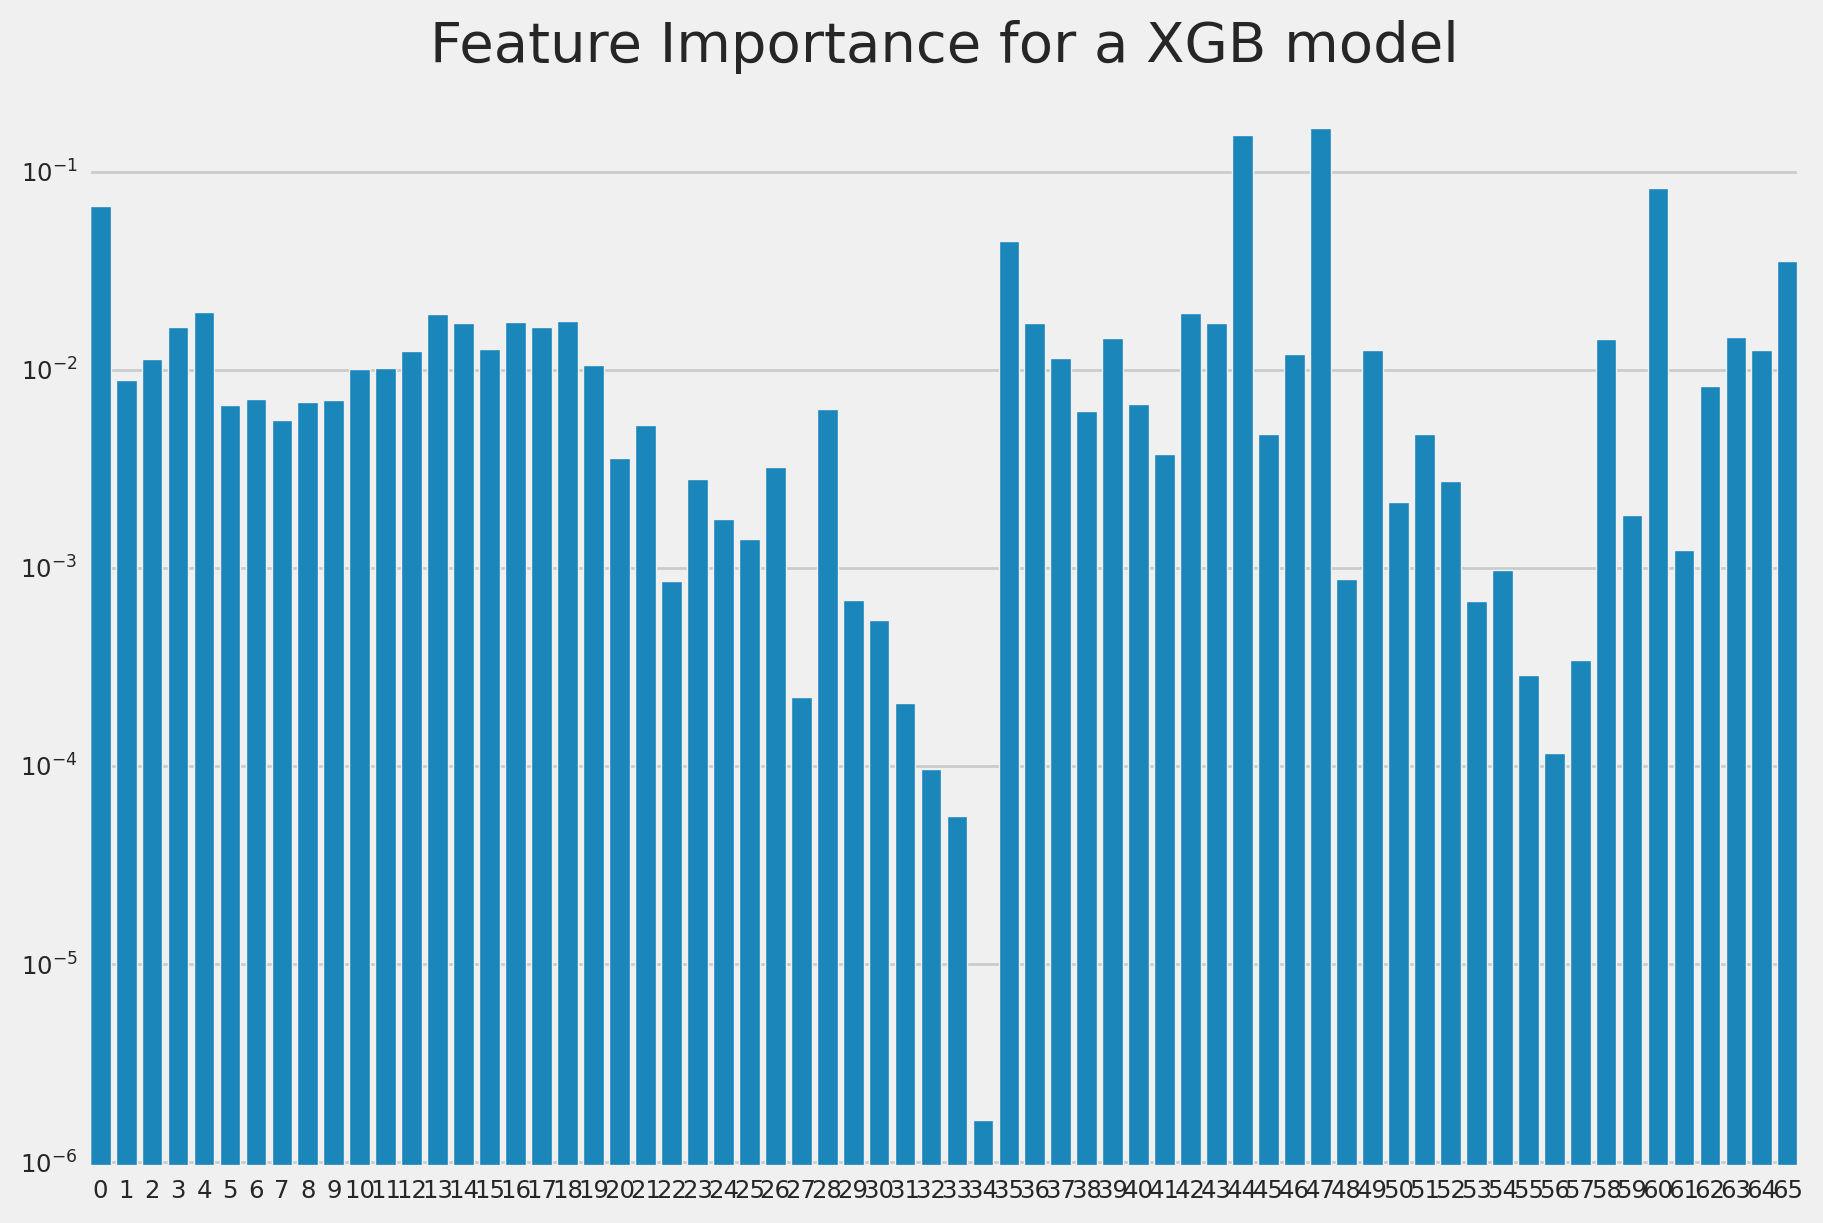

In [ ]:
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(model_xgb_best1.feature_importances_,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for a XGB model')
#ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
pass

In [ ]:
crop, crop_idx

(True, [-1, -2])

In [ ]:
col_vector = ['Category','BName','BName_sub']

In [ ]:
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : len(col_scalar)+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
col_scalar

[7, 6]


['quality', 'store', 'Author', 'Author_mul', 'Publshr', 'Pdate']

In [ ]:
col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
col_partition

[(0, 5),
 (5, 35),
 (35, 60),
 (60, 61),
 (61, 62),
 (62, 63),
 (63, 64),
 (64, 65),
 (65, 66)]

In [ ]:
cols_setting = list(zip(col_vector+col_scalar,col_partition))
fi_model =model_xgb_best1.feature_importances_
concatted_FI = dict()
for (col,partition) in cols_setting:
    concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
concatted_FI, sum(list(concatted_FI.values()))

({'Category': 0.12317565,
  'BName': 0.20386167,
  'BName_sub': 0.51823723,
  'quality': 0.08271266,
  'store': 0.0012266717,
  'Author': 0.008224858,
  'Author_mul': 0.014575561,
  'Publshr': 0.012483945,
  'Pdate': 0.035501737},
 0.999999983003363)

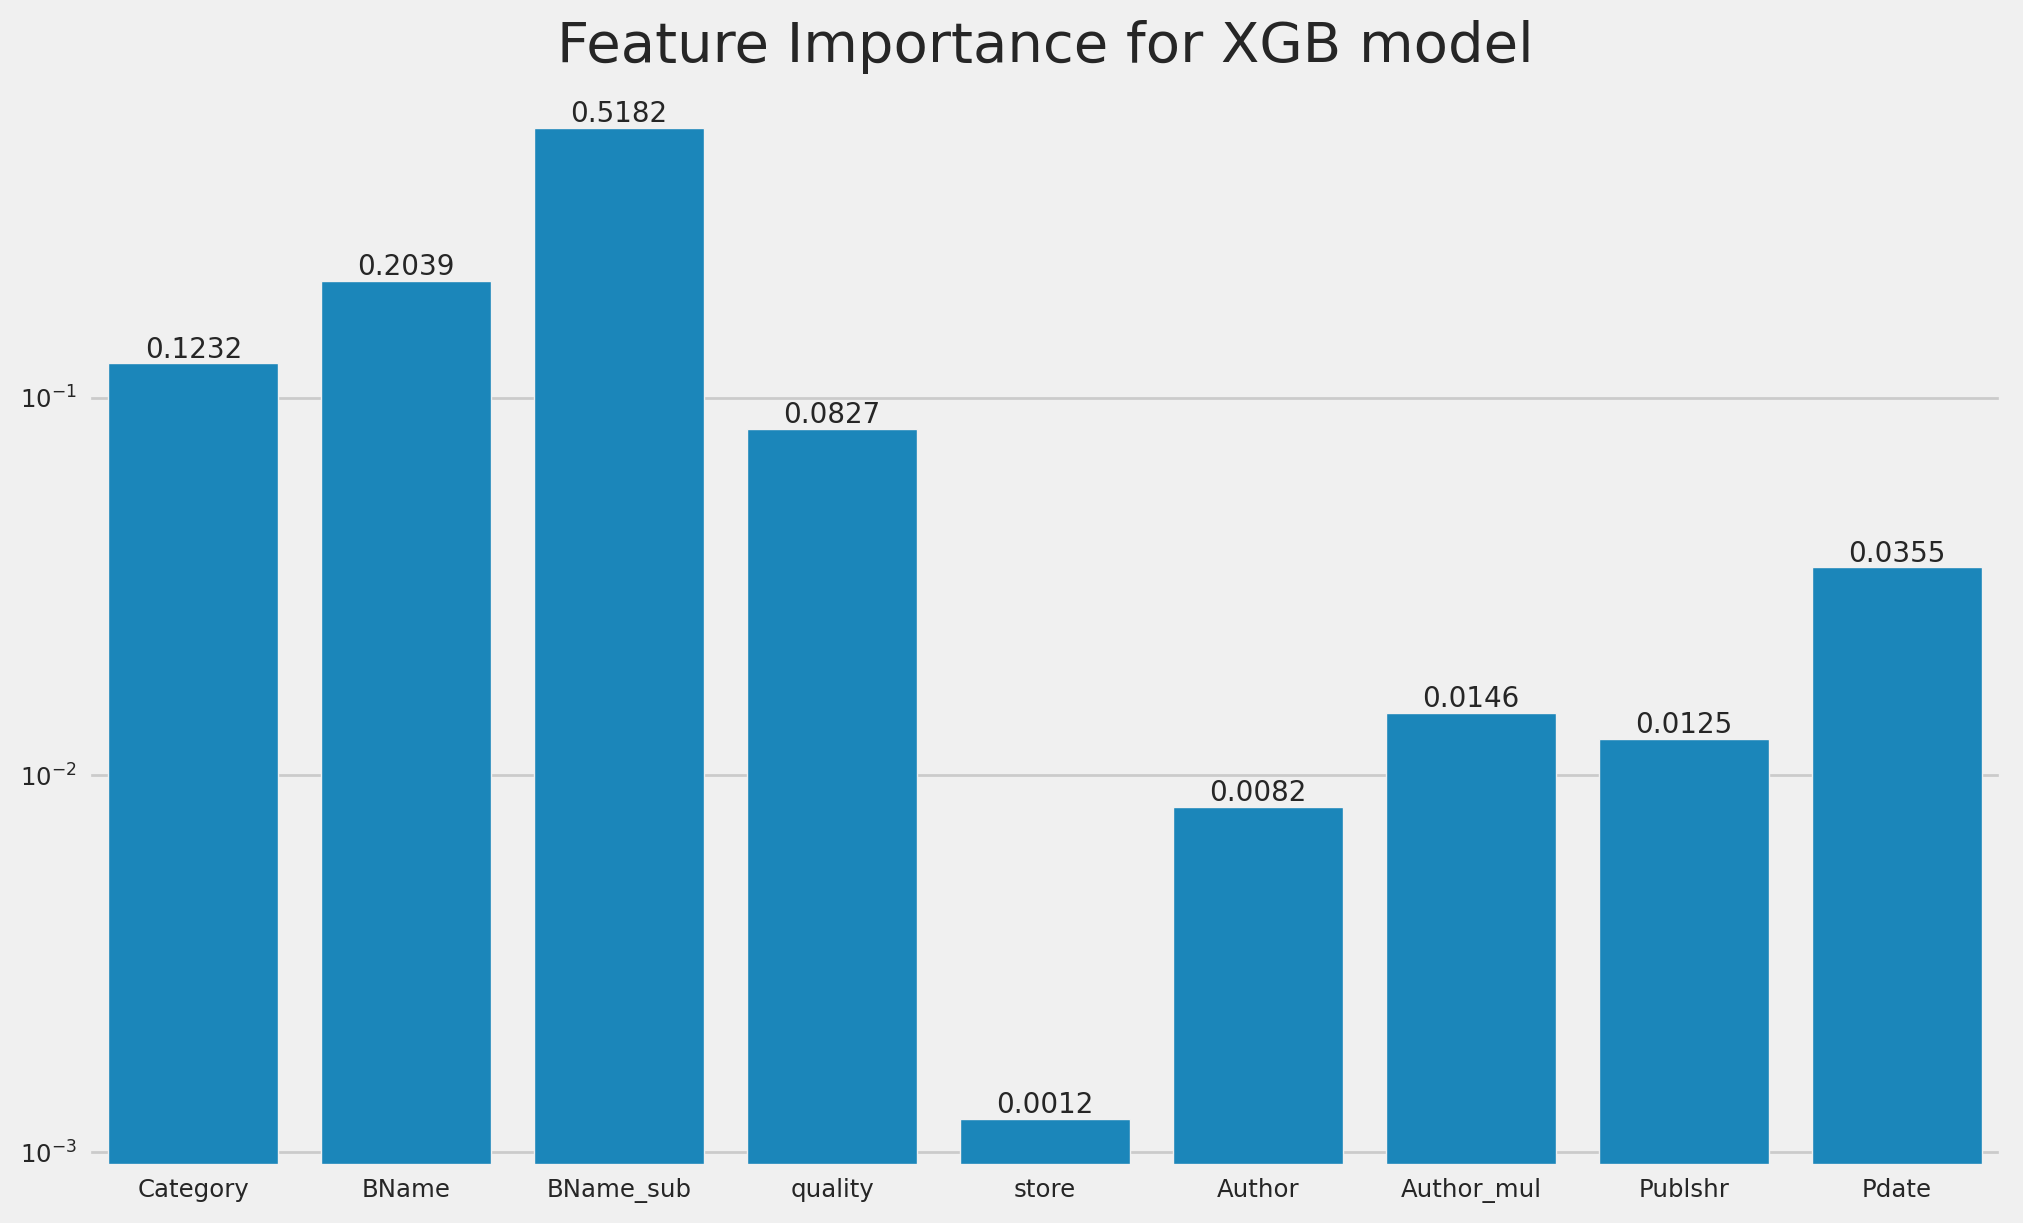

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(concatted_FI,ax=ax)
ax.set_yscale('log')
ax.set_title('Feature Importance for XGB model')
ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=10)
#ax.set_xticklabels([])
pass

- 만약 ItemId가 포함되지 않은 것들로 test set을 추리면 어떻게 될까

In [ ]:
#RSLT_DIR = PRJCT_PATH + 'processed/'
RSLT_DIR = './'
ver, strat = 1.0, False
file_name = 'data_splitted_ver{}_strat-{}.pkl'.format(ver,strat)
file_path = os.path.join(RSLT_DIR,file_name)
data = load_pkl(file_path)

file_name = 'bookinfo_ver{}.csv'.format(1.0)
file_path = os.path.join(RSLT_DIR,file_name)
bookinfo = pd.read_csv(file_path)

items=dict()
for mode,sample in data.items():
    items[mode]= set(sample['X']['ItemId'].values)

In [ ]:
display(len(items['val'].difference(items['train'])))
display(len(items['test'].difference(items['train'])))


4084

4984

In [ ]:
res_val = list(items['val'].difference(items['train']))
res_test = list(items['test'].difference(items['train']))
res_items = res_val+res_test
len(res_items)

9068

In [ ]:
cond_val_res = data['val']['X']['ItemId'].isin(res_val).to_numpy()
cond_test_res = data['test']['X']['ItemId'].isin(res_val).to_numpy()
display(np.sum(cond_val_res))
display(np.sum(cond_test_res))

4677

1451

In [ ]:
len(cond_val_res), len(cond_test_res)

(125474, 156843)

In [ ]:
len(y_val[cond_val_res]),len(y_test[cond_test_res])

(4677, 1451)

In [ ]:
X_res = np.vstack((X_val[cond_val_res],X_test[cond_test_res]))
y_res = np.hstack((y_val[cond_val_res],y_test[cond_test_res]))
X_res.shape, y_res.shape

((6128, 66), (6128,))

In [ ]:
pred4 = model_xgb.predict(X_res)
pred14 = model_xgb_best1.predict(X_res)
pred24 = model_xgb_best2.predict(X_res)

In [ ]:
print("default model")
display(make_reg_score_dict(y_res,pred4,np.mean(y_train)))
print("\nbest model")
display(make_reg_score_dict(y_res,pred14,np.mean(y_train)))
print("\nbest model2")
display(make_reg_score_dict(y_res,pred24,np.mean(y_train)))

default model


{'rmse': [3281.975224256985, 4837.522729624746],
 'mape': [0.41510861012572425, 0.5005390315845578],
 'mase': [0.5381059636159122, 1],
 'r2_score': [0.5270399664147916, 0]}


best model


{'rmse': [3308.4699891663417, 4837.522729624746],
 'mape': [0.4404562765066755, 0.5005390315845578],
 'mase': [0.5462103718982589, 1],
 'r2_score': [0.5193729097822335, 0]}


best model2


{'rmse': [3236.4311100995997, 4837.522729624746],
 'mape': [0.43944240749092445, 0.5005390315845578],
 'mase': [0.5407354794478483, 1],
 'r2_score': [0.5400754616581189, 0]}

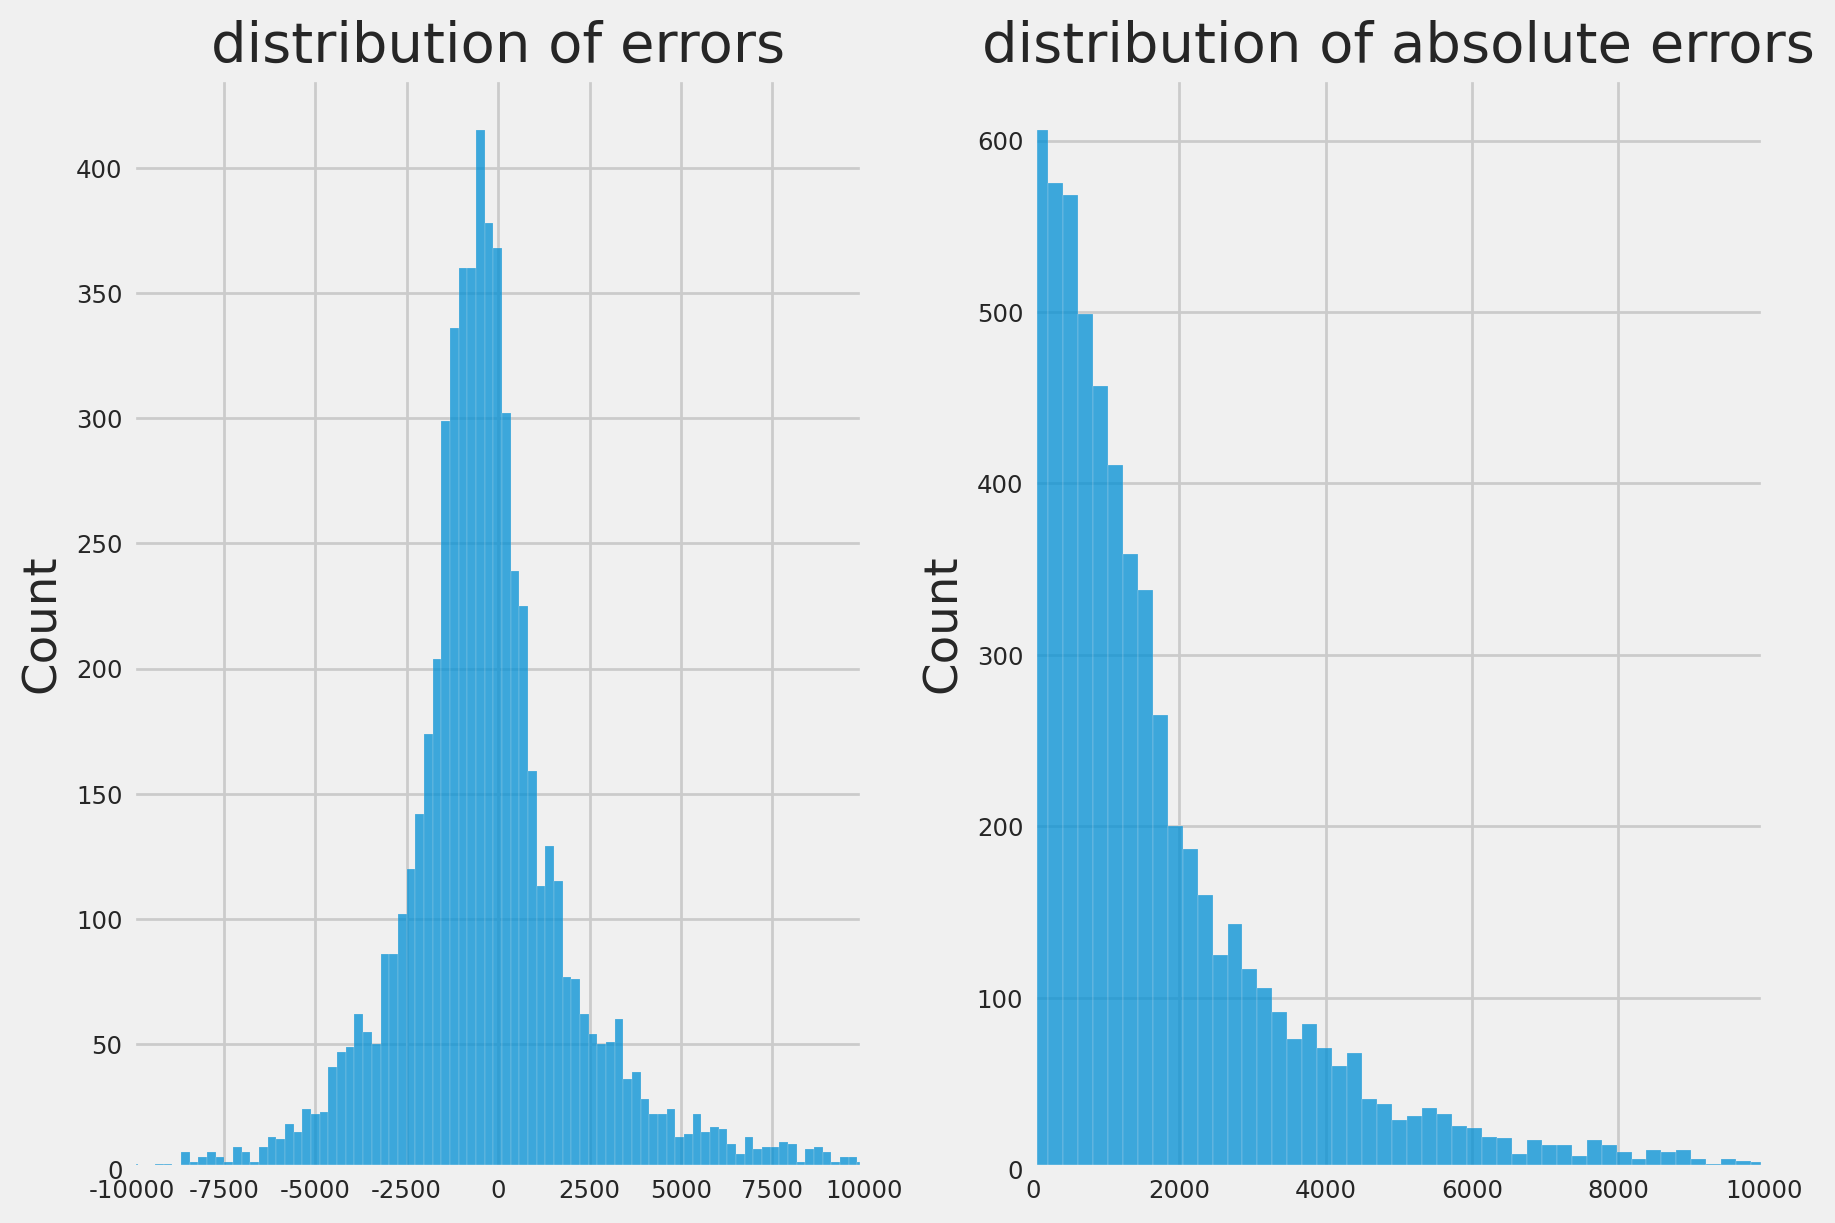

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
axes[0].set_xlim([-10000,10000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
axes[1].set_xlim([0,10000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');
pass

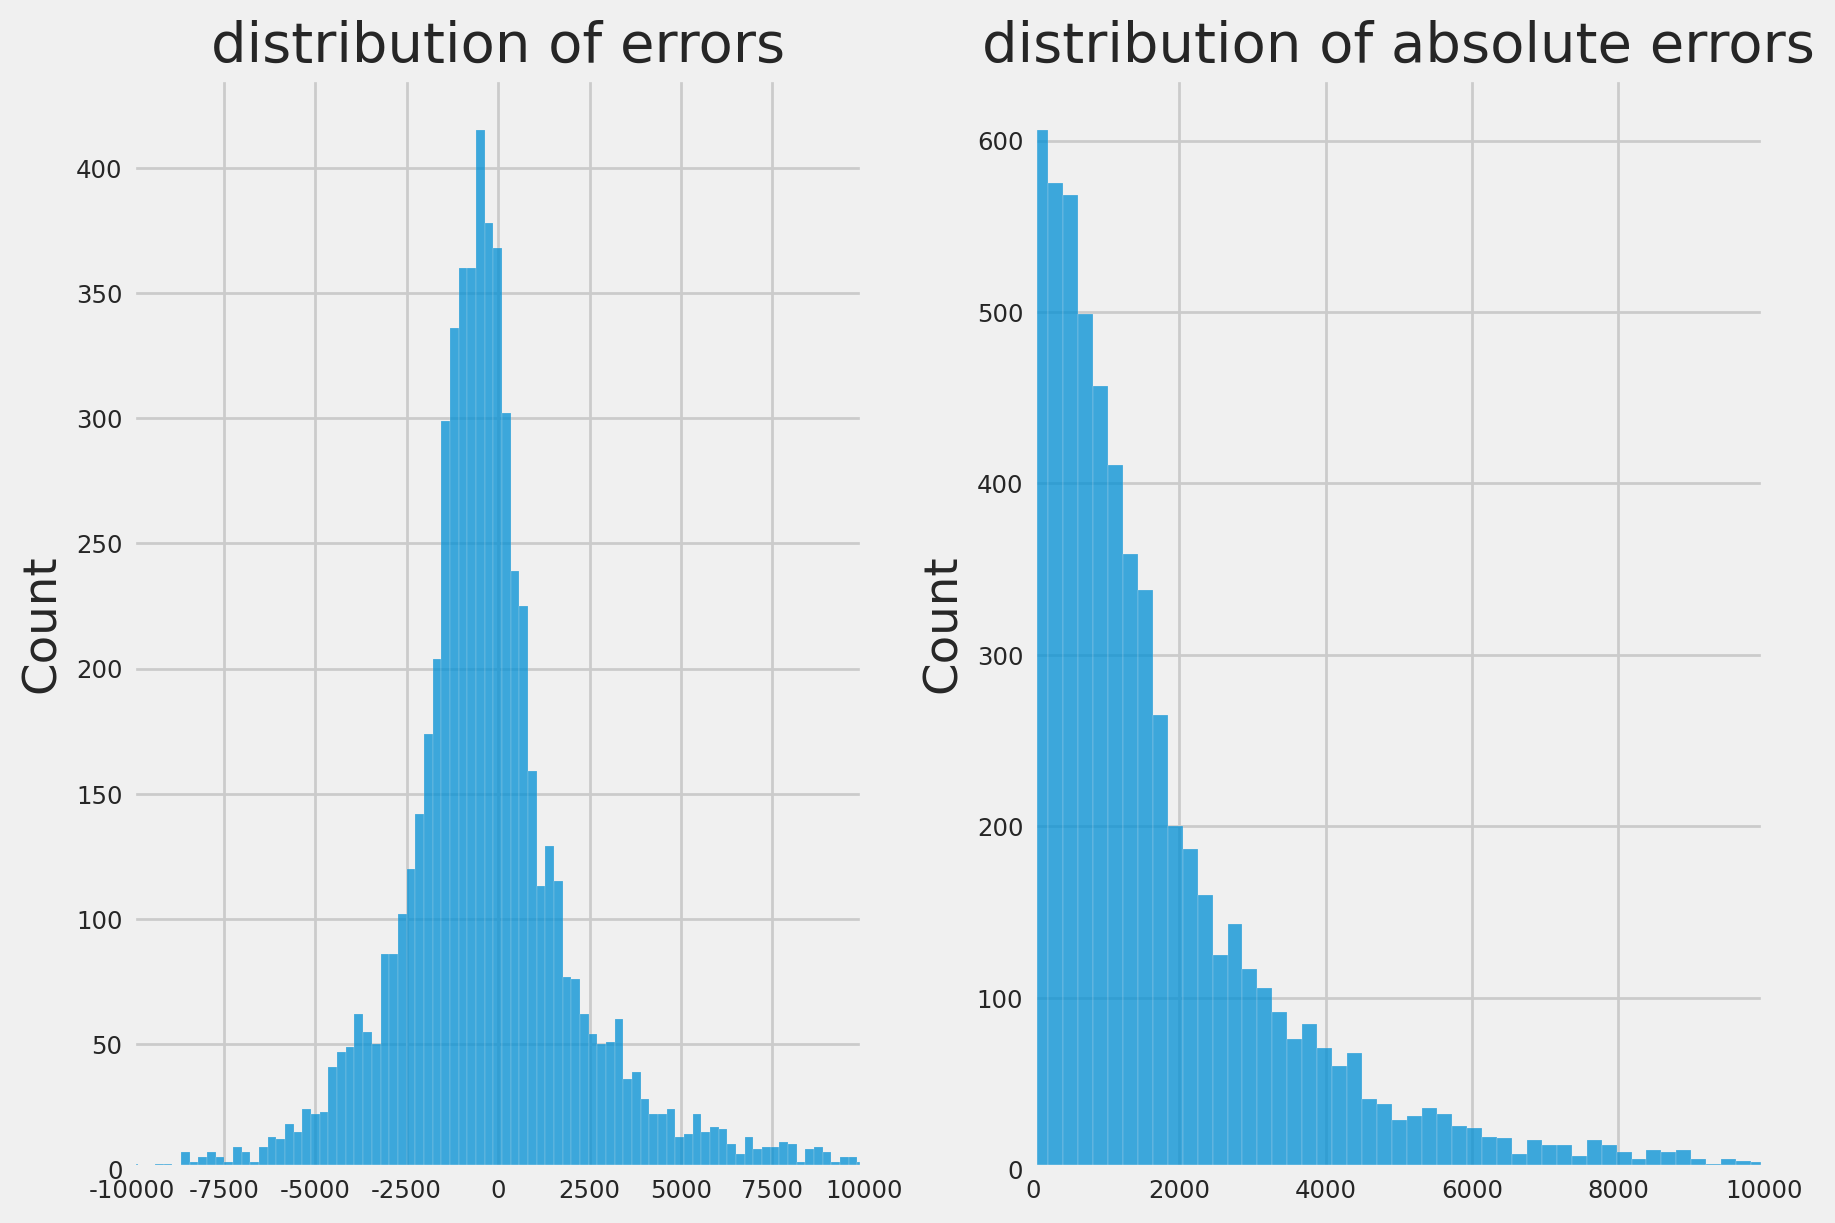

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (9,6))
sns.histplot((y_res-pred4),ax=axes[0])
axes[0].set_xlim([-10000,10000])
axes[0].set_title('distribution of errors')
sns.histplot(np.abs(y_res-pred4),ax=axes[1])
axes[1].set_xlim([0,10000])
axes[1].set_title('distribution of absolute errors')
#ax.set_yscale('log');
pass

# 세일즈 포인트 제외 - 그리드 서치

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 67)

(125474, 67)

(156843, 67)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
h_params = {
    'n_estimators':[700,2100],
    'learning_rate':[1,0.5,0.3,0.1],
    'max_depth':[4,5],
    'colsample_bytree':[0.3,0.5,1],
    'device':['cuda']
}

In [ ]:
xgbmodel = XGBRegressor()
GS_XGB = GridSearchCV(xgbmodel,param_grid=h_params,cv=2,n_jobs=-1,verbose=1)

In [ ]:
GS_XGB.fit(X_train,y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 1], 'device': ['cuda'],
                         'learning_rate': [1, 0.5, 0.3, 0.1],
                         'max_depth': [4, 5], 'n_estimators': [700, 2100]},
             verbose=1)

In [ ]:
display(GS_XGB.cv_results_['rank_test_score'])
great_idx = np.where(GS_XGB.cv_results_['rank_test_score']<8)
display(great_idx)
display(GS_XGB.cv_results_['mean_test_score'][great_idx])

array([45, 33, 36, 22, 37, 15, 21,  5, 42, 18, 24,  6, 48, 38, 44, 19, 40,
       23, 26, 20, 29, 10, 16,  3, 34, 12, 17,  2, 47, 30, 41, 13, 43, 32,
       39, 31, 25,  7, 14,  4, 28,  8, 11,  1, 46, 27, 35,  9],
      dtype=int32)

(array([ 7, 11, 23, 27, 37, 39, 43]),)

array([0.95933316, 0.95895278, 0.96000359, 0.96084455, 0.95719954,
       0.95940826, 0.96106631])

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<5)
display(best_idx)
GS_XGB.cv_results_['mean_test_score'][best_idx]

(array([23, 27, 39, 43]),)

array([0.96000359, 0.96084455, 0.95940826, 0.96106631])

In [ ]:
list(map(lambda x: GS_XGB.cv_results_['params'][x],best_idx[0]))

[{'colsample_bytree': 0.5,
  'device': 'cuda',
  'learning_rate': 0.5,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 0.5,
  'device': 'cuda',
  'learning_rate': 0.3,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'device': 'cuda',
  'learning_rate': 0.5,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'device': 'cuda',
  'learning_rate': 0.3,
  'max_depth': 5,
  'n_estimators': 2100}]

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<2)
test_params = GS_XGB.cv_results_['params'][best_idx[0][0]]

In [ ]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 68)

(125474, 68)

(156843, 68)

(501896,)

(125474,)

(156843,)

## XGB

**remove some col**
- -1 : SalesPoint
- -2 : RglrPrice

In [ ]:
#crop,crop_idx = False,[-1,-2]
#crop,crop_idx = True,[-2]
#crop,crop_idx = True,[-1]
crop,crop_idx = True,[-1,-2]
if crop :
    crop_idx2 = list(map(lambda x : X_train.shape[1]+x if x < 0 else x, crop_idx))
    crop_idx2 = sorted(crop_idx2,reverse=True)
    print(crop_idx2)
    for i in crop_idx2:
        X_train = np.hstack([X_train[:,:i],X_train[:,i+1:]])
        X_val = np.hstack([X_val[:,:i],X_val[:,i+1:]])
        X_test = np.hstack([X_test[:,:i],X_test[:,i+1:]])

[67, 66]


In [ ]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)
display(y_train.shape)
display(y_val.shape)
display(y_test.shape)

(501896, 66)

(125474, 66)

(156843, 66)

(501896,)

(125474,)

(156843,)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
h_params = {
    'n_estimators':[700,2100],
    'learning_rate':[1,0.5,0.3,0.1],
    'max_depth':[4,5],
    'colsample_bytree':[0.3,0.5,1],
    'device':['cuda']
}

In [ ]:
xgbmodel = XGBRegressor()
GS_XGB = GridSearchCV(xgbmodel,param_grid=h_params,cv=2,n_jobs=-1,verbose=1)

In [ ]:
GS_XGB.fit(X_train,y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 1], 'device': ['cuda'],
                         'learning_rate': [1, 0.5, 0.3, 0.1],
                         'max_depth': [4, 5], 'n_estimators': [700, 2100]},
             verbose=1)

In [ ]:
display(GS_XGB.cv_results_['rank_test_score'])
great_idx = np.where(GS_XGB.cv_results_['rank_test_score']<8)
display(great_idx)
display(GS_XGB.cv_results_['mean_test_score'][great_idx])

array([39, 21, 28,  8, 37, 18, 25,  5, 43, 27, 30,  9, 48, 41, 45, 29, 34,
       14, 23,  7, 33, 13, 17,  2, 40, 22, 26,  6, 47, 38, 44, 24, 32, 11,
       16,  4, 31, 10, 12,  1, 35, 15, 20,  3, 46, 36, 42, 19],
      dtype=int32)

(array([ 7, 19, 23, 27, 35, 39, 43]),)

array([0.84594985, 0.84100002, 0.85717795, 0.84592041, 0.84865448,
       0.86737402, 0.85685888])

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<5)
display(best_idx)
GS_XGB.cv_results_['mean_test_score'][best_idx]

(array([23, 35, 39, 43]),)

array([0.85717795, 0.84865448, 0.86737402, 0.85685888])

In [ ]:
list(map(lambda x: GS_XGB.cv_results_['params'][x],best_idx[0]))

[{'colsample_bytree': 0.5,
  'device': 'cuda',
  'learning_rate': 0.5,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'device': 'cuda',
  'learning_rate': 1,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'device': 'cuda',
  'learning_rate': 0.5,
  'max_depth': 5,
  'n_estimators': 2100},
 {'colsample_bytree': 1,
  'device': 'cuda',
  'learning_rate': 0.3,
  'max_depth': 5,
  'n_estimators': 2100}]

In [ ]:
best_idx = np.where(GS_XGB.cv_results_['rank_test_score']<2)
test_params = GS_XGB.cv_results_['params'][best_idx[0][0]]